In [1]:
import numpy as np
import struct
from array import array
import pandas as pd
import os
from os.path  import join
import random as rn
from sklearn.neural_network import MLPClassifier
import graphviz
import pydotplus
from IPython.display import Image
from io import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import log_loss
import random
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import time
import itertools
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import kurtosis
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection

In [2]:
"""
Loading in the dataset into a pandas dataframe object.

For the following segments the code snippets were retreved from: https://www.kaggle.com/code/anetakovacheva/interpreting-a-music-genre-classifier
"""

%matplotlib inline

input_path = 'data/musicgenre_datafolder'
file_path = join(input_path, 'music_genre.csv')

music_data = pd.read_csv(file_path)

"""
Cleaning and Pre-Processing all of the data
"""

"""
There are some duplicated data that needs to be cleaned up
"""
music_data.duplicated().any()
duplicated = music_data.duplicated()
music_data[duplicated]
music_data.iloc[9999:10006]
music_data.drop([10000, 10001, 10002, 10003, 10004], inplace = True)

"""
Removing some columns that don't matter or will complicated the training too much
"""
music_data.reset_index(inplace = True)
music_data = music_data.drop(["artist_name", "index", "instance_id", "track_name", "obtained_date"], axis = 1)

"""
Normalizing the music data such that it removes invalid values for 'tempo' and converts
the column values into a float
"""
music_data = music_data.drop(music_data[music_data["tempo"] == "?"].index)
music_data["tempo"] = music_data["tempo"].astype("float")
music_data["tempo"] = np.around(music_data["tempo"], decimals = 2)

"""
Encoding the columns that are strings with LabelEncoder since this will mess
up the algorithms that require numeric values
"""
key_encoder = LabelEncoder()
mode_encoder = LabelEncoder()
music_data["key"] = key_encoder.fit_transform(music_data["key"])
music_data["mode"] = mode_encoder.fit_transform(music_data["mode"])

"""
Separating out the column features from the music genre label
"""
music_features = music_data.drop("music_genre", axis = 1)
music_labels = music_data["music_genre"]

print(music_data)
print(np.unique(music_labels))
print(len(np.unique(music_labels)))

"""
Scaling the features out into a scale centered around 0 with a standard deviation of 1
"""
scaler = StandardScaler()
music_features_scaled = scaler.fit_transform(music_features)
# print(music_features_scaled[0])

"""
Splitting the data into Training and Testing Data Sets
"""
train_features, test_features, train_labels, test_labels = train_test_split(
    music_features_scaled, music_labels, test_size = 0.1, stratify = music_labels)


       popularity  acousticness  danceability  duration_ms  energy  \
0            27.0       0.00468         0.652         -1.0   0.941   
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
...           ...           ...           ...          ...     ...   
49995        59.0       0.03340         0.913         -1.0   0.574   
49996        72.0       0.15700         0.709     251860.0   0.362   
49997        51.0       0.00597         0.693     189483.0   0.763   
49998        65.0       0.08310         0.782     262773.0   0.472   
49999        67.0       0.10200         0.862     267267.0   0.642   

       instrumentalness  key  liveness  loudness  mode  speechiness   tempo  \
0               0.79200    1     0.115    -5.201     1       0.0748  100.89   
1

In [3]:
"""
Setting up seed values for reproducability
"""
seed = 1234
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
"""
Getting the size values for the training and testing dataset
"""
size_train_samples = np.shape(train_features)[0]
size_test_samples = np.shape(test_features)[0]

In [39]:
number_of_epochs = 150

In [40]:
"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list_reg = []
avg_validation_scores_list_reg = []
avg_train_loss_values_reg = []
avg_validation_loss_values_reg = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(train_features, train_labels, test_size=0.2, random_state=seed)
    
    clf.fit(train_data, train_label)
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list_reg.append(accuracy_score)
    avg_validation_scores_list_reg.append(validation_score)
    avg_train_loss_values_reg.append(train_loss_score)
    avg_validation_loss_values_reg.append(val_loss_score)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("=============================================")

    

/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 1 epoch
Training Score: 0.3769667427654717
Validation Score: 0.36833662388943733
Training Loss Score: 1.7637387310154444
Validation Loss Score: 1.7810482710120141


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 2 epoch
Training Score: 0.49506386129450236
Validation Score: 0.4834649555774926
Training Loss Score: 1.3682209315465756
Validation Loss Score: 1.390458634915841


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 3 epoch
Training Score: 0.5236009131856605
Validation Score: 0.5123395853899309
Training Loss Score: 1.2627703326275277
Validation Loss Score: 1.2909060882316723


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 4 epoch
Training Score: 0.5372986980934165
Validation Score: 0.5209772951628825
Training Loss Score: 1.2263759195979942
Validation Loss Score: 1.2574706380263136


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 5 epoch
Training Score: 0.5434997223421978
Validation Score: 0.5261599210266535
Training Loss Score: 1.207079799054452
Validation Loss Score: 1.2398100816895647


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 6 epoch
Training Score: 0.547973098044055
Validation Score: 0.5304787759131293
Training Loss Score: 1.1944534456665339
Validation Loss Score: 1.2278776959634294


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 7 epoch
Training Score: 0.5509347812673536
Validation Score: 0.5349210266535045
Training Loss Score: 1.1850063995520956
Validation Loss Score: 1.2189841313718839


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 8 epoch
Training Score: 0.553279447152465
Validation Score: 0.535167818361303
Training Loss Score: 1.1775153657785933
Validation Loss Score: 1.212182438337619


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 9 epoch
Training Score: 0.5552847535015734
Validation Score: 0.5373889437314906
Training Loss Score: 1.1711697164310688
Validation Loss Score: 1.2062723940035605


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 10 epoch
Training Score: 0.5572592089837725
Validation Score: 0.5384995064165844
Training Loss Score: 1.1657266805690993
Validation Loss Score: 1.2011689258288414


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 11 epoch
Training Score: 0.5601900413401617
Validation Score: 0.5388696939782823
Training Loss Score: 1.160825313209245
Validation Loss Score: 1.196880553561671


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 12 epoch
Training Score: 0.5618868390201764
Validation Score: 0.5405972359328727
Training Loss Score: 1.1565169493449947
Validation Loss Score: 1.1929619384421621


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 13 epoch
Training Score: 0.5629666193620041
Validation Score: 0.5418311944718658
Training Loss Score: 1.1524058248523397
Validation Loss Score: 1.189161687283872


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 14 epoch
Training Score: 0.5638612945023755
Validation Score: 0.543558736426456
Training Loss Score: 1.1485971860032398
Validation Loss Score: 1.185695021818338


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 15 epoch
Training Score: 0.5646325661751095
Validation Score: 0.543928923988154
Training Loss Score: 1.1451565072711443
Validation Loss Score: 1.1825958149446958


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 16 epoch
Training Score: 0.5654655395816622
Validation Score: 0.5447926949654491
Training Loss Score: 1.1420199287098098
Validation Loss Score: 1.1796666921538739


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 17 epoch
Training Score: 0.5658666008514839
Validation Score: 0.5465202369200395
Training Loss Score: 1.1391253037103986
Validation Loss Score: 1.1771605526320499


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 18 epoch
Training Score: 0.5669155303264022
Validation Score: 0.5480009871668312
Training Loss Score: 1.13646239193061
Validation Loss Score: 1.1748871817147288


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 19 epoch
Training Score: 0.5683346702042328
Validation Score: 0.5487413622902271
Training Loss Score: 1.13390868955471
Validation Loss Score: 1.1727952544977855


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 20 epoch
Training Score: 0.5693527488122416
Validation Score: 0.5492349457058243
Training Loss Score: 1.1314473777520797
Validation Loss Score: 1.1706570256827238


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 21 epoch
Training Score: 0.5695378540136978
Validation Score: 0.5504689042448174
Training Loss Score: 1.1290607776786727
Validation Loss Score: 1.1685769886375434


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 22 epoch
Training Score: 0.5702165730857037
Validation Score: 0.5505923000987167
Training Loss Score: 1.1267964600210296
Validation Loss Score: 1.166555562822471


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 23 epoch
Training Score: 0.5709569938915283
Validation Score: 0.5508390918065152
Training Loss Score: 1.1247128177320505
Validation Loss Score: 1.1650247338405224


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 24 epoch
Training Score: 0.5713580551613501
Validation Score: 0.5521964461994077
Training Loss Score: 1.1226226468712202
Validation Loss Score: 1.1633185299700202


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 25 epoch
Training Score: 0.5723144320355402
Validation Score: 0.5533070088845015
Training Loss Score: 1.1206358422392069
Validation Loss Score: 1.1617582339250176


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 26 epoch
Training Score: 0.5734250632442771
Validation Score: 0.5540473840078973
Training Loss Score: 1.118768411359045
Validation Loss Score: 1.160222463376455


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 27 epoch
Training Score: 0.5738261245140989
Validation Score: 0.5549111549851925
Training Loss Score: 1.1169579608169873
Validation Loss Score: 1.1588605829765044


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 28 epoch
Training Score: 0.5744122909853767
Validation Score: 0.555898321816387
Training Loss Score: 1.115249895586374
Validation Loss Score: 1.1574315675004205


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 29 epoch
Training Score: 0.5741963349170112
Validation Score: 0.5568854886475815
Training Loss Score: 1.1135078900758613
Validation Loss Score: 1.1558623641189638


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 30 epoch
Training Score: 0.5738569753810082
Validation Score: 0.5568854886475815
Training Loss Score: 1.111952397042366
Validation Loss Score: 1.154684331526464


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 31 epoch
Training Score: 0.5742271857839205
Validation Score: 0.5581194471865746
Training Loss Score: 1.1102915880993653
Validation Loss Score: 1.153214792460775


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 32 epoch
Training Score: 0.5753069661257482
Validation Score: 0.557872655478776
Training Loss Score: 1.1088218412553916
Validation Loss Score: 1.1520891483303033


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 33 epoch
Training Score: 0.5761399395323008
Validation Score: 0.5583662388943732
Training Loss Score: 1.1072845991835636
Validation Loss Score: 1.1508795621065528


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 34 epoch
Training Score: 0.5770346146726723
Validation Score: 0.5588598223099703
Training Loss Score: 1.105879434478667
Validation Loss Score: 1.1497884431708565


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 35 epoch
Training Score: 0.5776824828777689
Validation Score: 0.5581194471865746
Training Loss Score: 1.1044652242120407
Validation Loss Score: 1.1486676242713196


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 36 epoch
Training Score: 0.5781760967483186
Validation Score: 0.5582428430404739
Training Loss Score: 1.1031140886246775
Validation Loss Score: 1.1477888118047506


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 37 epoch
Training Score: 0.5785463071512309
Validation Score: 0.5597235932872655
Training Loss Score: 1.1018176353422795
Validation Loss Score: 1.1469353804121931


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 38 epoch
Training Score: 0.5790090701548714
Validation Score: 0.5599703849950641
Training Loss Score: 1.100542758292432
Validation Loss Score: 1.1458919349396008


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 39 epoch
Training Score: 0.579317578823965
Validation Score: 0.5609575518262586
Training Loss Score: 1.0993487750893027
Validation Loss Score: 1.1449308049171052


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 40 epoch
Training Score: 0.5789473684210527
Validation Score: 0.5608341559723593
Training Loss Score: 1.0981869505195254
Validation Loss Score: 1.1439557810341965


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 41 epoch
Training Score: 0.5795952366261492
Validation Score: 0.5614511352418559
Training Loss Score: 1.0970784259394508
Validation Loss Score: 1.1431343877193352


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 42 epoch
Training Score: 0.5798420435614241
Validation Score: 0.5616979269496545
Training Loss Score: 1.0960554967310838
Validation Loss Score: 1.1422437063181718


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 43 epoch
Training Score: 0.5801197013636084
Validation Score: 0.5616979269496545
Training Loss Score: 1.0950435251102075
Validation Loss Score: 1.1414019625252458


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 44 epoch
Training Score: 0.5809218239032516
Validation Score: 0.5612043435340572
Training Loss Score: 1.0941759251644254
Validation Loss Score: 1.1408706841238503


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 45 epoch
Training Score: 0.5811994817054359
Validation Score: 0.5625616979269497
Training Loss Score: 1.0932771588149548
Validation Loss Score: 1.1402503226065142


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 46 epoch
Training Score: 0.581631393842167
Validation Score: 0.5628084896347483
Training Loss Score: 1.0923136761183394
Validation Loss Score: 1.1395798510558512


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 47 epoch
Training Score: 0.5814462886407108
Validation Score: 0.5639190523198421
Training Loss Score: 1.0913951541912452
Validation Loss Score: 1.1389951101266234


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 48 epoch
Training Score: 0.5816005429752577
Validation Score: 0.5635488647581441
Training Loss Score: 1.0905925570027084
Validation Loss Score: 1.1385712182593657


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 49 epoch
Training Score: 0.58197075337817
Validation Score: 0.5646594274432379
Training Loss Score: 1.0898042091636193
Validation Loss Score: 1.138052814152273


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 50 epoch
Training Score: 0.581723946442895
Validation Score: 0.5653998025666338
Training Loss Score: 1.0889109939215391
Validation Loss Score: 1.1372678585452913


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 51 epoch
Training Score: 0.5819399025112606
Validation Score: 0.5656465942744324
Training Loss Score: 1.0880365154481668
Validation Loss Score: 1.136663580649486


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 52 epoch
Training Score: 0.5823409637810822
Validation Score: 0.5657699901283317
Training Loss Score: 1.0872268138587498
Validation Loss Score: 1.1360593338817497


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 53 epoch
Training Score: 0.5823718146479916
Validation Score: 0.565893385982231
Training Loss Score: 1.0863629386187583
Validation Loss Score: 1.135509913824704


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 54 epoch
Training Score: 0.5825877707163571
Validation Score: 0.566263573543929
Training Loss Score: 1.0855802050821253
Validation Loss Score: 1.1350048282551854


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 55 epoch
Training Score: 0.5834515949898192
Validation Score: 0.5655231984205331
Training Loss Score: 1.0848052661121552
Validation Loss Score: 1.1344159415820785


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 56 epoch
Training Score: 0.5837909545258222
Validation Score: 0.5656465942744324
Training Loss Score: 1.084047100871847
Validation Loss Score: 1.1337362131720965


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 57 epoch
Training Score: 0.5841303140618251
Validation Score: 0.5652764067127345
Training Loss Score: 1.0832831497134698
Validation Loss Score: 1.133096873291368


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 58 epoch
Training Score: 0.5841303140618251
Validation Score: 0.5660167818361304
Training Loss Score: 1.0825717489911812
Validation Loss Score: 1.132651823194685


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 59 epoch
Training Score: 0.5846856296661936
Validation Score: 0.5650296150049359
Training Loss Score: 1.0818034503884295
Validation Loss Score: 1.1321042065622489


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 60 epoch
Training Score: 0.5846239279323749
Validation Score: 0.5657699901283317
Training Loss Score: 1.0811706144191182
Validation Loss Score: 1.1317076536868411


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 61 epoch
Training Score: 0.5845005244647374
Validation Score: 0.5653998025666338
Training Loss Score: 1.080530516098633
Validation Loss Score: 1.1313175573952234


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 62 epoch
Training Score: 0.5848398840007404
Validation Score: 0.5657699901283317
Training Loss Score: 1.0798334547424504
Validation Loss Score: 1.1308605347260121


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 63 epoch
Training Score: 0.5846239279323749
Validation Score: 0.5665103652517275
Training Loss Score: 1.079252991295725
Validation Loss Score: 1.1305264428635873


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 64 epoch
Training Score: 0.5850249892021966
Validation Score: 0.566263573543929
Training Loss Score: 1.0785761268965794
Validation Loss Score: 1.1301412251842822


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 65 epoch
Training Score: 0.5852409452705621
Validation Score: 0.5661401776900297
Training Loss Score: 1.0778444387108304
Validation Loss Score: 1.1295302562406138


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 66 epoch
Training Score: 0.5854569013389276
Validation Score: 0.5657699901283317
Training Loss Score: 1.0772246577559477
Validation Loss Score: 1.1293041940543525


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 67 epoch
Training Score: 0.5854569013389276
Validation Score: 0.5665103652517275
Training Loss Score: 1.0765800188237695
Validation Loss Score: 1.1289190559013673


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 68 epoch
Training Score: 0.5855803048065651
Validation Score: 0.5667571569595261
Training Loss Score: 1.0760185261714537
Validation Loss Score: 1.128616293535618


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 69 epoch
Training Score: 0.5853026470043808
Validation Score: 0.5660167818361304
Training Loss Score: 1.0754445245385962
Validation Loss Score: 1.1282989937832824


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 70 epoch
Training Score: 0.5854260504720182
Validation Score: 0.5672507403751234
Training Loss Score: 1.07491344524509
Validation Loss Score: 1.1280803418254057


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 71 epoch
Training Score: 0.5854260504720182
Validation Score: 0.5672507403751234
Training Loss Score: 1.0744217368482516
Validation Loss Score: 1.1278793747138103


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 72 epoch
Training Score: 0.5857962608749306
Validation Score: 0.5668805528134254
Training Loss Score: 1.073869878206271
Validation Loss Score: 1.127550220918952


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 73 epoch
Training Score: 0.5862281730116616
Validation Score: 0.5666337611056268
Training Loss Score: 1.0732713231010156
Validation Loss Score: 1.1271855403543212


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 74 epoch
Training Score: 0.5863824273462084
Validation Score: 0.5668805528134254
Training Loss Score: 1.0727906914818568
Validation Loss Score: 1.1269412480363314


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 75 epoch
Training Score: 0.5864132782131178
Validation Score: 0.5672507403751234
Training Loss Score: 1.0723600509505364
Validation Loss Score: 1.1268299139877271


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 76 epoch
Training Score: 0.5866600851483926
Validation Score: 0.5677443237907206
Training Loss Score: 1.0718923892963534
Validation Loss Score: 1.1266205688277502


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 77 epoch
Training Score: 0.5865366816807552
Validation Score: 0.5665103652517275
Training Loss Score: 1.0713858789268844
Validation Loss Score: 1.1263445179759406


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 78 epoch
Training Score: 0.5871536990189424
Validation Score: 0.5666337611056268
Training Loss Score: 1.0709109650416568
Validation Loss Score: 1.1260992360583197


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 79 epoch
Training Score: 0.5868143394829395
Validation Score: 0.5666337611056268
Training Loss Score: 1.0704485912076074
Validation Loss Score: 1.1258428248970158


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 80 epoch
Training Score: 0.5868451903498488
Validation Score: 0.5665103652517275
Training Loss Score: 1.0699136357515429
Validation Loss Score: 1.1254479543569875


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 81 epoch
Training Score: 0.5872462516196705
Validation Score: 0.566263573543929
Training Loss Score: 1.0694379414048534
Validation Loss Score: 1.1252354046517379


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 82 epoch
Training Score: 0.5877707163571296
Validation Score: 0.5666337611056268
Training Loss Score: 1.0688447073974003
Validation Loss Score: 1.1248693574492696


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 83 epoch
Training Score: 0.5883260319614981
Validation Score: 0.5672507403751234
Training Loss Score: 1.068276498247498
Validation Loss Score: 1.124561335436683


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 84 epoch
Training Score: 0.5886036897636824
Validation Score: 0.5673741362290227
Training Loss Score: 1.067778656454015
Validation Loss Score: 1.1242673778896728


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 85 epoch
Training Score: 0.5881409267600419
Validation Score: 0.5678677196446199
Training Loss Score: 1.0672590121058239
Validation Loss Score: 1.1239208685272375


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 86 epoch
Training Score: 0.5887579440982291
Validation Score: 0.5684846989141165
Training Loss Score: 1.0667679787691455
Validation Loss Score: 1.1237149801782138


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 87 epoch
Training Score: 0.5884185845622262
Validation Score: 0.5688548864758144
Training Loss Score: 1.0663497665152961
Validation Loss Score: 1.1234548642468345


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 88 epoch
Training Score: 0.5888504966989573
Validation Score: 0.5686080947680158
Training Loss Score: 1.0658417677008545
Validation Loss Score: 1.1231505695208257


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 89 epoch
Training Score: 0.5891281545011415
Validation Score: 0.5682379072063178
Training Loss Score: 1.0653474775177072
Validation Loss Score: 1.1228462188284556


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 90 epoch
Training Score: 0.5894983649040538
Validation Score: 0.5687314906219151
Training Loss Score: 1.0648719825786859
Validation Loss Score: 1.1226824093043344


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 91 epoch
Training Score: 0.5896217683716912
Validation Score: 0.5682379072063178
Training Loss Score: 1.0644266703552345
Validation Loss Score: 1.1224781331517943


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 92 epoch
Training Score: 0.5897143209724193
Validation Score: 0.5687314906219151
Training Loss Score: 1.0639717971559313
Validation Loss Score: 1.1222499897254254


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 93 epoch
Training Score: 0.5898994261738755
Validation Score: 0.569101678183613
Training Loss Score: 1.0635548509554278
Validation Loss Score: 1.1220067978885113


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 94 epoch
Training Score: 0.5900536805084223
Validation Score: 0.5684846989141165
Training Loss Score: 1.0631547980310976
Validation Loss Score: 1.1218284249608563


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 95 epoch
Training Score: 0.5895600666378725
Validation Score: 0.5687314906219151
Training Loss Score: 1.0627411400454647
Validation Loss Score: 1.121658847513666


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 96 epoch
Training Score: 0.5895909175047819
Validation Score: 0.569101678183613
Training Loss Score: 1.062308500014504
Validation Loss Score: 1.1213371974718935


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 97 epoch
Training Score: 0.5902387857098784
Validation Score: 0.5687314906219151
Training Loss Score: 1.0618159393686675
Validation Loss Score: 1.1211102545784237


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 98 epoch
Training Score: 0.590547294378972
Validation Score: 0.5686080947680158
Training Loss Score: 1.0612730547279339
Validation Loss Score: 1.1206231490992795


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 99 epoch
Training Score: 0.5905781452458814
Validation Score: 0.5683613030602171
Training Loss Score: 1.0609159861953703
Validation Loss Score: 1.1204367419488739


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 100 epoch
Training Score: 0.5905781452458814
Validation Score: 0.5683613030602171
Training Loss Score: 1.0605101356213333
Validation Loss Score: 1.1202153205097258


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 101 epoch
Training Score: 0.590547294378972
Validation Score: 0.5686080947680158
Training Loss Score: 1.0601125357970673
Validation Loss Score: 1.1200067212693345


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 102 epoch
Training Score: 0.590454741778244
Validation Score: 0.5688548864758144
Training Loss Score: 1.0596421935001898
Validation Loss Score: 1.1196686690719462


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 103 epoch
Training Score: 0.5907632504473376
Validation Score: 0.569101678183613
Training Loss Score: 1.0592299988122984
Validation Loss Score: 1.119381233992453


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 104 epoch
Training Score: 0.590547294378972
Validation Score: 0.5689782823297137
Training Loss Score: 1.0588518538042218
Validation Loss Score: 1.1192621657272905


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 105 epoch
Training Score: 0.5908558030480656
Validation Score: 0.5692250740375123
Training Loss Score: 1.058505735771908
Validation Loss Score: 1.1191347872744906


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 106 epoch
Training Score: 0.5910717591164312
Validation Score: 0.5693484698914116
Training Loss Score: 1.058174559291384
Validation Loss Score: 1.1190328865675607


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 107 epoch
Training Score: 0.5911951625840686
Validation Score: 0.5692250740375123
Training Loss Score: 1.0578677127401102
Validation Loss Score: 1.1189215010329712


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 108 epoch
Training Score: 0.591226013450978
Validation Score: 0.5693484698914116
Training Loss Score: 1.057492221815265
Validation Loss Score: 1.118773888207438


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 109 epoch
Training Score: 0.5910100573826125
Validation Score: 0.5703356367226061
Training Loss Score: 1.0571843094821787
Validation Loss Score: 1.1187928581731323


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 110 epoch
Training Score: 0.5911334608502499
Validation Score: 0.5703356367226061
Training Loss Score: 1.0567840131775932
Validation Loss Score: 1.118540580051184


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 111 epoch
Training Score: 0.5908249521811563
Validation Score: 0.5709526159921027
Training Loss Score: 1.0565157498000288
Validation Loss Score: 1.118500764526578


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 112 epoch
Training Score: 0.590454741778244
Validation Score: 0.5708292201382034
Training Loss Score: 1.056188591638173
Validation Loss Score: 1.118310129503411


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 113 epoch
Training Score: 0.5906089961127907
Validation Score: 0.5705824284304047
Training Loss Score: 1.0559315459578034
Validation Loss Score: 1.1182233469784584


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 114 epoch
Training Score: 0.5906398469797002
Validation Score: 0.5704590325765054
Training Loss Score: 1.0555662696500572
Validation Loss Score: 1.1179460863312698


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 115 epoch
Training Score: 0.590547294378972
Validation Score: 0.570705824284304
Training Loss Score: 1.0552135954518616
Validation Loss Score: 1.1178078511123217


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 116 epoch
Training Score: 0.5903621891775159
Validation Score: 0.5708292201382034
Training Loss Score: 1.0549305975923544
Validation Loss Score: 1.1176680536526638


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 117 epoch
Training Score: 0.5903313383106066
Validation Score: 0.5711994076999013
Training Loss Score: 1.0546301583706175
Validation Loss Score: 1.1174381504868185


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 118 epoch
Training Score: 0.590454741778244
Validation Score: 0.571076011846002
Training Loss Score: 1.0543529492066193
Validation Loss Score: 1.117222887539162


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 119 epoch
Training Score: 0.5907323995804282
Validation Score: 0.5709526159921027
Training Loss Score: 1.0540546279158929
Validation Loss Score: 1.1170426425914717


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 120 epoch
Training Score: 0.5907941013142469
Validation Score: 0.5704590325765054
Training Loss Score: 1.0537623045242055
Validation Loss Score: 1.1169192425347625


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 121 epoch
Training Score: 0.5910409082495218
Validation Score: 0.570705824284304
Training Loss Score: 1.0535427440564937
Validation Loss Score: 1.1169003787706184


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 122 epoch
Training Score: 0.5914419695193435
Validation Score: 0.5698420533070089
Training Loss Score: 1.0532062389435635
Validation Loss Score: 1.1166682728985753


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 123 epoch
Training Score: 0.5914111186524341
Validation Score: 0.5695952615992103
Training Loss Score: 1.0529123760229886
Validation Loss Score: 1.116500351704851


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 124 epoch
Training Score: 0.5913494169186154
Validation Score: 0.569101678183613
Training Loss Score: 1.0526971915021468
Validation Loss Score: 1.1166149256567648


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 125 epoch
Training Score: 0.5911643117171592
Validation Score: 0.5693484698914116
Training Loss Score: 1.0524381890985643
Validation Loss Score: 1.1164606862566369


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 126 epoch
Training Score: 0.5914419695193435
Validation Score: 0.569471865745311
Training Loss Score: 1.0521413470291416
Validation Loss Score: 1.1162318340315425


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 127 epoch
Training Score: 0.5915345221200716
Validation Score: 0.5695952615992103
Training Loss Score: 1.0518870517859875
Validation Loss Score: 1.1162064592530712


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 128 epoch
Training Score: 0.5915036712531622
Validation Score: 0.569101678183613
Training Loss Score: 1.051609755399583
Validation Loss Score: 1.116076300407884


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 129 epoch
Training Score: 0.5911026099833405
Validation Score: 0.5703356367226061
Training Loss Score: 1.051286515518341
Validation Loss Score: 1.1159064967037697


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 130 epoch
Training Score: 0.5912877151847967
Validation Score: 0.5703356367226061
Training Loss Score: 1.0510119663972655
Validation Loss Score: 1.1156773531012378


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 131 epoch
Training Score: 0.5911026099833405
Validation Score: 0.5702122408687068
Training Loss Score: 1.0507965188651898
Validation Loss Score: 1.1156722350434525


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 132 epoch
Training Score: 0.5911334608502499
Validation Score: 0.569101678183613
Training Loss Score: 1.050448794688647
Validation Loss Score: 1.1153817086859985


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 133 epoch
Training Score: 0.5913494169186154
Validation Score: 0.5688548864758144
Training Loss Score: 1.0502224715046928
Validation Loss Score: 1.1152745028839264


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 134 epoch
Training Score: 0.5913802677855248
Validation Score: 0.569471865745311
Training Loss Score: 1.0498819388099212
Validation Loss Score: 1.1150521059484337


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 135 epoch
Training Score: 0.5913494169186154
Validation Score: 0.569101678183613
Training Loss Score: 1.049659563408432
Validation Loss Score: 1.1150311285734267


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 136 epoch
Training Score: 0.5914111186524341
Validation Score: 0.5686080947680158
Training Loss Score: 1.049409093276726
Validation Loss Score: 1.1148950965100066


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 137 epoch
Training Score: 0.5915962238538903
Validation Score: 0.5683613030602171
Training Loss Score: 1.0491583123642416
Validation Loss Score: 1.1147456011158285


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 138 epoch
Training Score: 0.5913185660517061
Validation Score: 0.5681145113524185
Training Loss Score: 1.0489042868496656
Validation Loss Score: 1.1146901063487502


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 139 epoch
Training Score: 0.591657925587709
Validation Score: 0.5687314906219151
Training Loss Score: 1.0484606369703102
Validation Loss Score: 1.1143671632027181


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 140 epoch
Training Score: 0.59208983772444
Validation Score: 0.5676209279368213
Training Loss Score: 1.048199782045943
Validation Loss Score: 1.1142782219377512


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 141 epoch
Training Score: 0.591997285123712
Validation Score: 0.5682379072063178
Training Loss Score: 1.0479309390783835
Validation Loss Score: 1.1141100432282085


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 142 epoch
Training Score: 0.591997285123712
Validation Score: 0.5682379072063178
Training Loss Score: 1.047672321650806
Validation Loss Score: 1.1140660521646182


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 143 epoch
Training Score: 0.5920589868575307
Validation Score: 0.5679911154985192
Training Loss Score: 1.0473581941869214
Validation Loss Score: 1.1139291650674816


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 144 epoch
Training Score: 0.5918121799222558
Validation Score: 0.5681145113524185
Training Loss Score: 1.0471102492802342
Validation Loss Score: 1.113904340211529


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 145 epoch
Training Score: 0.5920281359906213
Validation Score: 0.5683613030602171
Training Loss Score: 1.046770306161377
Validation Loss Score: 1.1136302167968641


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 146 epoch
Training Score: 0.5917504781884371
Validation Score: 0.5686080947680158
Training Loss Score: 1.0465584310584706
Validation Loss Score: 1.1135989381837494


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 147 epoch
Training Score: 0.5918121799222558
Validation Score: 0.5677443237907206
Training Loss Score: 1.0462909557004458
Validation Loss Score: 1.1133649008358004


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 148 epoch
Training Score: 0.5919047325229839
Validation Score: 0.5670039486673247
Training Loss Score: 1.0460519858663975
Validation Loss Score: 1.113293721511119


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 149 epoch
Training Score: 0.5918121799222558
Validation Score: 0.5670039486673247
Training Loss Score: 1.045805231821253
Validation Loss Score: 1.1130185882738448
Run for 150 epoch
Training Score: 0.5923366446597149
Validation Score: 0.5670039486673247
Training Loss Score: 1.0456521261233966
Validation Loss Score: 1.1130087805638353


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [58]:
"""
Computing Accuracy Score on the Test data
"""

clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=number_of_epochs,
    warm_start=warm_start,
    random_state=seed
)

clf.fit(train_features, train_labels)
start_time = time.time()
score = clf.score(test_features, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.5895157707685473
0.004446983337402344


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


In [59]:
"""
Running PCA DR on the dataset and then feeding the DR dataset to the neural network.
"""
svd_solver = "full"
pcafinal = PCA(n_components = 10, svd_solver = svd_solver)

pcafinal.fit(train_features)

x_train_transformed_pca = pcafinal.transform(train_features)
x_test_transformed_pca = pcafinal.transform(test_features)

In [42]:
"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list_pca = []
avg_validation_scores_list_pca = []
avg_train_loss_values_pca = []
avg_validation_loss_values_pca = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(x_train_transformed_pca, train_labels, test_size=0.2, random_state=seed)
    
    clf.fit(train_data, train_label)
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list_pca.append(accuracy_score)
    avg_validation_scores_list_pca.append(validation_score)
    avg_train_loss_values_pca.append(train_loss_score)
    avg_validation_loss_values_pca.append(val_loss_score)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("=============================================")



/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 1 epoch
Training Score: 0.38606774850373293
Validation Score: 0.3741362290227048
Training Loss Score: 1.713606816502146
Validation Loss Score: 1.7253741254596662


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 2 epoch
Training Score: 0.4817979885234775
Validation Score: 0.46384501480750245
Training Loss Score: 1.3935496353264054
Validation Loss Score: 1.411015482891296


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 3 epoch
Training Score: 0.49639044857160486
Validation Score: 0.47828232971372164
Training Loss Score: 1.3204312809364598
Validation Loss Score: 1.3434452189118897


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 4 epoch
Training Score: 0.5038872092305794
Validation Score: 0.4866732477788746
Training Loss Score: 1.2962381004296921
Validation Loss Score: 1.3208621674733148


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 5 epoch
Training Score: 0.5098722774109953
Validation Score: 0.49247285291214216
Training Loss Score: 1.2815709011239111
Validation Loss Score: 1.307109297200179


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 6 epoch
Training Score: 0.5144382057135806
Validation Score: 0.49555774925962487
Training Loss Score: 1.2706704286512551
Validation Loss Score: 1.2972829212406312


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 7 epoch
Training Score: 0.5174307398037885
Validation Score: 0.4971618953603159
Training Loss Score: 1.2618152435090702
Validation Loss Score: 1.289292123919718


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 8 epoch
Training Score: 0.5189115814154378
Validation Score: 0.4988894373149062
Training Loss Score: 1.2543999658013485
Validation Loss Score: 1.2828757560173099


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 9 epoch
Training Score: 0.5209477386314555
Validation Score: 0.5018509378084897
Training Loss Score: 1.2479316741169615
Validation Loss Score: 1.2774376602837574


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 10 epoch
Training Score: 0.522274325908558
Validation Score: 0.5044422507403751
Training Loss Score: 1.2420119375655643
Validation Loss Score: 1.272463465221122


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 11 epoch
Training Score: 0.5229838958474733
Validation Score: 0.5069101678183613
Training Loss Score: 1.236621372659058
Validation Loss Score: 1.267968673977176


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 12 epoch
Training Score: 0.5252360091318566
Validation Score: 0.5088845014807503
Training Loss Score: 1.2316402375105786
Validation Loss Score: 1.2638659908411873


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 13 epoch
Training Score: 0.5267168507435059
Validation Score: 0.5106120434353406
Training Loss Score: 1.2270414499104596
Validation Loss Score: 1.2600580045302532


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 14 epoch
Training Score: 0.5288147096933424
Validation Score: 0.5117226061204343
Training Loss Score: 1.222911957881216
Validation Loss Score: 1.2567755039358381


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 15 epoch
Training Score: 0.5298636391682606
Validation Score: 0.5119693978282329
Training Loss Score: 1.2191451504218587
Validation Loss Score: 1.2538442764253126


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 16 epoch
Training Score: 0.5310359721108163
Validation Score: 0.5136969397828233
Training Loss Score: 1.215537365909961
Validation Loss Score: 1.250936679441984


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 17 epoch
Training Score: 0.5320849015857345
Validation Score: 0.5153010858835143
Training Loss Score: 1.2120350898938501
Validation Loss Score: 1.2481553307116884


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 18 epoch
Training Score: 0.532547664589375
Validation Score: 0.5162882527147088
Training Loss Score: 1.2086953240662255
Validation Loss Score: 1.245388968210771


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 19 epoch
Training Score: 0.5335348923304745
Validation Score: 0.5185093780848964
Training Loss Score: 1.2056420246358832
Validation Loss Score: 1.2431174527927675


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 20 epoch
Training Score: 0.5349848830752144
Validation Score: 0.5193731490621916
Training Loss Score: 1.2026728377376084
Validation Loss Score: 1.2408706875040452


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 21 epoch
Training Score: 0.5364348738199544
Validation Score: 0.5186327739387957
Training Loss Score: 1.1998004232397583
Validation Loss Score: 1.2387165686942225


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 22 epoch
Training Score: 0.5381008206330598
Validation Score: 0.5204837117472852
Training Loss Score: 1.197010999010596
Validation Loss Score: 1.236446612743367


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 23 epoch
Training Score: 0.5383167767014253
Validation Score: 0.5203603158933859
Training Loss Score: 1.1943389216596496
Validation Loss Score: 1.2342363014371402


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 24 epoch
Training Score: 0.5386252853705189
Validation Score: 0.5202369200394866
Training Loss Score: 1.1918028510734957
Validation Loss Score: 1.232041665358459


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 25 epoch
Training Score: 0.5390263466403405
Validation Score: 0.5213474827245804
Training Loss Score: 1.1893701543200699
Validation Loss Score: 1.22994528690037


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 26 epoch
Training Score: 0.5396433639785277
Validation Score: 0.5223346495557749
Training Loss Score: 1.1870957708539953
Validation Loss Score: 1.2279785425079794


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 27 epoch
Training Score: 0.541371012525452
Validation Score: 0.5217176702862784
Training Loss Score: 1.1848804647430082
Validation Loss Score: 1.2260895501448672


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 28 epoch
Training Score: 0.541802924662183
Validation Score: 0.5227048371174728
Training Loss Score: 1.1826155170276067
Validation Loss Score: 1.224208801825397


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 29 epoch
Training Score: 0.5421114333312766
Validation Score: 0.5214708785784797
Training Loss Score: 1.1805738462752284
Validation Loss Score: 1.2226515877725277


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 30 epoch
Training Score: 0.5427593015363732
Validation Score: 0.5214708785784797
Training Loss Score: 1.178683034180527
Validation Loss Score: 1.2210800212075401


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 31 epoch
Training Score: 0.5439933362127476
Validation Score: 0.5220878578479763
Training Loss Score: 1.1768616163391952
Validation Loss Score: 1.2195733019860073


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 32 epoch
Training Score: 0.5451039674214846
Validation Score: 0.5225814412635735
Training Loss Score: 1.175102336412909
Validation Loss Score: 1.2180100173972561


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 33 epoch
Training Score: 0.5455050286913062
Validation Score: 0.5225814412635735
Training Loss Score: 1.173543620242361
Validation Loss Score: 1.2168310293713203


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 34 epoch
Training Score: 0.5462763003640402
Validation Score: 0.523568608094768
Training Loss Score: 1.1720314518405357
Validation Loss Score: 1.215685831490572


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 35 epoch
Training Score: 0.5469241685691368
Validation Score: 0.5230750246791708
Training Loss Score: 1.170651122387868
Validation Loss Score: 1.214632860053995


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 36 epoch
Training Score: 0.5476337385080521
Validation Score: 0.5244323790720632
Training Loss Score: 1.1693150998168098
Validation Loss Score: 1.2136782968093605


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 37 epoch
Training Score: 0.5479422471771457
Validation Score: 0.5249259624876604
Training Loss Score: 1.1680906888007747
Validation Loss Score: 1.2127979383159775


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 38 epoch
Training Score: 0.5482816067131486
Validation Score: 0.5260365251727542
Training Loss Score: 1.1668992595441259
Validation Loss Score: 1.211978240934042


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 39 epoch
Training Score: 0.5493305361880669
Validation Score: 0.5275172754195459
Training Loss Score: 1.1657599036931245
Validation Loss Score: 1.2112111838276607


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 40 epoch
Training Score: 0.5503177639291664
Validation Score: 0.5280108588351431
Training Loss Score: 1.1645664269717002
Validation Loss Score: 1.2103356655838364


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 41 epoch
Training Score: 0.5509347812673536
Validation Score: 0.5278874629812438
Training Loss Score: 1.163461945751899
Validation Loss Score: 1.209491733833603


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 42 epoch
Training Score: 0.5511815882026285
Validation Score: 0.5272704837117473
Training Loss Score: 1.1623992215028947
Validation Loss Score: 1.2086319026766559


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 43 epoch
Training Score: 0.5515209477386315
Validation Score: 0.5277640671273445
Training Loss Score: 1.1613718137060405
Validation Loss Score: 1.2078381051785798


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 44 epoch
Training Score: 0.5519220090084531
Validation Score: 0.5282576505429417
Training Loss Score: 1.1605169099792039
Validation Loss Score: 1.2071916816408057


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 45 epoch
Training Score: 0.5525698772135497
Validation Score: 0.5285044422507403
Training Loss Score: 1.1596391684114316
Validation Loss Score: 1.206516518887033


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 46 epoch
Training Score: 0.5529709384833714
Validation Score: 0.528381046396841
Training Loss Score: 1.1585906557577181
Validation Loss Score: 1.205625676120005


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 47 epoch
Training Score: 0.5525390263466403
Validation Score: 0.5291214215202369
Training Loss Score: 1.157681117673528
Validation Loss Score: 1.204889636905152


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 48 epoch
Training Score: 0.5528475350157339
Validation Score: 0.5298617966436328
Training Loss Score: 1.156875993049056
Validation Loss Score: 1.2042489087173263


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 49 epoch
Training Score: 0.5528475350157339
Validation Score: 0.5307255676209279
Training Loss Score: 1.1561489751110299
Validation Loss Score: 1.2037229080601333


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 50 epoch
Training Score: 0.5533719997531931
Validation Score: 0.5297384007897334
Training Loss Score: 1.1554083461251923
Validation Loss Score: 1.2032309830141235


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 51 epoch
Training Score: 0.553279447152465
Validation Score: 0.5308489634748272
Training Loss Score: 1.154657651229708
Validation Loss Score: 1.202719088922988


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 52 epoch
Training Score: 0.5539273153575616
Validation Score: 0.5315893385982231
Training Loss Score: 1.153899433322645
Validation Loss Score: 1.2021255891064995


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 53 epoch
Training Score: 0.5542358240266552
Validation Score: 0.5314659427443238
Training Loss Score: 1.1532513681960104
Validation Loss Score: 1.2016106911025515


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 54 epoch
Training Score: 0.5539581662244709
Validation Score: 0.5310957551826259
Training Loss Score: 1.1524825417361093
Validation Loss Score: 1.2009764921311705


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 55 epoch
Training Score: 0.5542975257604739
Validation Score: 0.5324531095755183
Training Loss Score: 1.1517670120190842
Validation Loss Score: 1.2003974774497073


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 56 epoch
Training Score: 0.5545751835626581
Validation Score: 0.532329713721619
Training Loss Score: 1.151199576406026
Validation Loss Score: 1.1999984327551854


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 57 epoch
Training Score: 0.5549762448324798
Validation Score: 0.5322063178677197
Training Loss Score: 1.1505365292471623
Validation Loss Score: 1.19944377049924


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 58 epoch
Training Score: 0.5553156043684827
Validation Score: 0.5320829220138203
Training Loss Score: 1.149969318465037
Validation Loss Score: 1.199026006154052


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 59 epoch
Training Score: 0.5552230517677547
Validation Score: 0.5318361303060217
Training Loss Score: 1.1493123591372976
Validation Loss Score: 1.1985339223013938


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 60 epoch
Training Score: 0.5554390078361202
Validation Score: 0.5333168805528135
Training Loss Score: 1.148724558153159
Validation Loss Score: 1.1979751128786889


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 61 epoch
Training Score: 0.5553464552353922
Validation Score: 0.5324531095755183
Training Loss Score: 1.1483108315045536
Validation Loss Score: 1.1975715962797655


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 62 epoch
Training Score: 0.5555315604368483
Validation Score: 0.5325765054294176
Training Loss Score: 1.1477563333719298
Validation Loss Score: 1.197134227945847


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 63 epoch
Training Score: 0.5555624113037576
Validation Score: 0.5328232971372162
Training Loss Score: 1.147273689593972
Validation Loss Score: 1.196798007363616


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 64 epoch
Training Score: 0.5553464552353922
Validation Score: 0.5328232971372162
Training Loss Score: 1.146646328314562
Validation Loss Score: 1.1963557358983774


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 65 epoch
Training Score: 0.5554390078361202
Validation Score: 0.5324531095755183
Training Loss Score: 1.146059562798449
Validation Loss Score: 1.1959511831220249


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 66 epoch
Training Score: 0.556271981242673
Validation Score: 0.5322063178677197
Training Loss Score: 1.1454523383031856
Validation Loss Score: 1.1956358662391326


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 67 epoch
Training Score: 0.5565804899117666
Validation Score: 0.5338104639684107
Training Loss Score: 1.1449257912707405
Validation Loss Score: 1.1953764530260593


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 68 epoch
Training Score: 0.5571666563830444
Validation Score: 0.5340572556762093
Training Loss Score: 1.144436649284461
Validation Loss Score: 1.1950604130643603


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 69 epoch
Training Score: 0.5576294193866848
Validation Score: 0.5336870681145114
Training Loss Score: 1.1439352674965175
Validation Loss Score: 1.1946969007397479


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 70 epoch
Training Score: 0.5578453754550503
Validation Score: 0.5347976307996052
Training Loss Score: 1.1433804238500385
Validation Loss Score: 1.1944250035044341


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 71 epoch
Training Score: 0.5583389893256
Validation Score: 0.5345508390918066
Training Loss Score: 1.1428766017194762
Validation Loss Score: 1.1941276165608419


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 72 epoch
Training Score: 0.5582772875917813
Validation Score: 0.53393385982231
Training Loss Score: 1.1424073490507463
Validation Loss Score: 1.1937792422746487


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 73 epoch
Training Score: 0.5578762263219597
Validation Score: 0.5338104639684107
Training Loss Score: 1.1419383953870517
Validation Loss Score: 1.1934936361268598


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 74 epoch
Training Score: 0.5580613315234159
Validation Score: 0.5340572556762093
Training Loss Score: 1.14141746573041
Validation Loss Score: 1.193195601273007


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 75 epoch
Training Score: 0.5581538841241439
Validation Score: 0.5335636722606121
Training Loss Score: 1.140899878059374
Validation Loss Score: 1.1928595408192542


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 76 epoch
Training Score: 0.5580613315234159
Validation Score: 0.5338104639684107
Training Loss Score: 1.1403588041747197
Validation Loss Score: 1.192568874844949


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 77 epoch
Training Score: 0.5580921823903252
Validation Score: 0.5341806515301086
Training Loss Score: 1.1399170595168027
Validation Loss Score: 1.1923750446002153


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 78 epoch
Training Score: 0.5582772875917813
Validation Score: 0.5347976307996052
Training Loss Score: 1.1395036086821089
Validation Loss Score: 1.1922365824525214


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 79 epoch
Training Score: 0.5588634540630592
Validation Score: 0.5355380059230009
Training Loss Score: 1.13905703293377
Validation Loss Score: 1.191973888345487


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 80 epoch
Training Score: 0.5588017523292405
Validation Score: 0.5356614017769002
Training Loss Score: 1.1385424732222307
Validation Loss Score: 1.1916913163595995


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 81 epoch
Training Score: 0.5588017523292405
Validation Score: 0.5356614017769002
Training Loss Score: 1.1381181556801923
Validation Loss Score: 1.191381918246307


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 82 epoch
Training Score: 0.5592953661997903
Validation Score: 0.5359081934846989
Training Loss Score: 1.1376230978730273
Validation Loss Score: 1.190965574792401


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 83 epoch
Training Score: 0.5597581292034306
Validation Score: 0.5361549851924975
Training Loss Score: 1.1372076378502973
Validation Loss Score: 1.1907080808540815


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 84 epoch
Training Score: 0.5599740852717962
Validation Score: 0.5366485686080947
Training Loss Score: 1.1368235349301477
Validation Loss Score: 1.1904748233249007


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 85 epoch
Training Score: 0.5601591904732522
Validation Score: 0.5377591312931885
Training Loss Score: 1.1364218887832234
Validation Loss Score: 1.190179159840876


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 86 epoch
Training Score: 0.5600974887394335
Validation Score: 0.5383761105626851
Training Loss Score: 1.135991152546983
Validation Loss Score: 1.18981438038189


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 87 epoch
Training Score: 0.5603442956747084
Validation Score: 0.5384995064165844
Training Loss Score: 1.1356977697055128
Validation Loss Score: 1.1896515994456078


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 88 epoch
Training Score: 0.5607145060776207
Validation Score: 0.5382527147087858
Training Loss Score: 1.1353093386232282
Validation Loss Score: 1.1893643580630069


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 89 epoch
Training Score: 0.5612389708150799
Validation Score: 0.5378825271470878
Training Loss Score: 1.1349846222449451
Validation Loss Score: 1.1891620793833269


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 90 epoch
Training Score: 0.5612389708150799
Validation Score: 0.5386229022704837
Training Loss Score: 1.1346363030924531
Validation Loss Score: 1.1889083299288192


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 91 epoch
Training Score: 0.5614857777503548
Validation Score: 0.5384995064165844
Training Loss Score: 1.134232998496632
Validation Loss Score: 1.1887336774223591


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 92 epoch
Training Score: 0.5615474794841735
Validation Score: 0.5388696939782823
Training Loss Score: 1.1339094453604388
Validation Loss Score: 1.1884664837660819


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 93 epoch
Training Score: 0.5613932251496268
Validation Score: 0.5393632773938796
Training Loss Score: 1.133558215232461
Validation Loss Score: 1.188324294669711


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 94 epoch
Training Score: 0.5613932251496268
Validation Score: 0.5389930898321816
Training Loss Score: 1.1331878836807976
Validation Loss Score: 1.18802373389742


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 95 epoch
Training Score: 0.5616091812179922
Validation Score: 0.5398568608094768
Training Loss Score: 1.1330139212976331
Validation Loss Score: 1.1879740736483893


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 96 epoch
Training Score: 0.5617017338187204
Validation Score: 0.5405972359328727
Training Loss Score: 1.1325216024306228
Validation Loss Score: 1.1874853687265126


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 97 epoch
Training Score: 0.5616091812179922
Validation Score: 0.5413376110562685
Training Loss Score: 1.132186575092658
Validation Loss Score: 1.1872407206487974


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 98 epoch
Training Score: 0.561763435552539
Validation Score: 0.5410908193484699
Training Loss Score: 1.1318750550434673
Validation Loss Score: 1.186913662777883


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 99 epoch
Training Score: 0.5618559881532671
Validation Score: 0.5412142152023692
Training Loss Score: 1.1314735785740153
Validation Loss Score: 1.1865146486719909


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 100 epoch
Training Score: 0.5621336459554513
Validation Score: 0.540720631786772
Training Loss Score: 1.1310815528873126
Validation Loss Score: 1.1860902757406175


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 101 epoch
Training Score: 0.5619176898870858
Validation Score: 0.5414610069101679
Training Loss Score: 1.1308386208714525
Validation Loss Score: 1.185836443508366


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 102 epoch
Training Score: 0.5619793916209046
Validation Score: 0.5415844027640672
Training Loss Score: 1.1305711978554072
Validation Loss Score: 1.1855859675504619


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 103 epoch
Training Score: 0.5619176898870858
Validation Score: 0.5418311944718658
Training Loss Score: 1.1302990889260336
Validation Loss Score: 1.1852868732714275


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 104 epoch
Training Score: 0.562102795088542
Validation Score: 0.5424481737413623
Training Loss Score: 1.129965955684456
Validation Loss Score: 1.1849955962395615


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 105 epoch
Training Score: 0.5619793916209046
Validation Score: 0.5433119447186574
Training Loss Score: 1.1297429300816206
Validation Loss Score: 1.184798787942697


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 106 epoch
Training Score: 0.5623804528907262
Validation Score: 0.5434353405725567
Training Loss Score: 1.129507049024166
Validation Loss Score: 1.1845751995168468


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 107 epoch
Training Score: 0.5623496020238169
Validation Score: 0.543558736426456
Training Loss Score: 1.1292813819405672
Validation Loss Score: 1.1844136706365842


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 108 epoch
Training Score: 0.56219534768927
Validation Score: 0.5431885488647581
Training Loss Score: 1.1289868921037032
Validation Loss Score: 1.1842378250822452


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 109 epoch
Training Score: 0.5622570494230887
Validation Score: 0.5428183613030603
Training Loss Score: 1.1287965333472885
Validation Loss Score: 1.1841040104270335


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 110 epoch
Training Score: 0.562534707225273
Validation Score: 0.5424481737413623
Training Loss Score: 1.1286324089518385
Validation Loss Score: 1.1840442948754515


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 111 epoch
Training Score: 0.5625038563583636
Validation Score: 0.5434353405725567
Training Loss Score: 1.1284411408096635
Validation Loss Score: 1.1839649044193592


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 112 epoch
Training Score: 0.5632442771641883
Validation Score: 0.5442991115498519
Training Loss Score: 1.1281649076748161
Validation Loss Score: 1.1837735818415787


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 113 epoch
Training Score: 0.5630283210958228
Validation Score: 0.5433119447186574
Training Loss Score: 1.1279842031532883
Validation Loss Score: 1.1836663303067791


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 114 epoch
Training Score: 0.5634293823656444
Validation Score: 0.5430651530108588
Training Loss Score: 1.1276792363696049
Validation Loss Score: 1.183399659399004


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 115 epoch
Training Score: 0.5635527858332819
Validation Score: 0.543558736426456
Training Loss Score: 1.1274697805728233
Validation Loss Score: 1.1831766553826568


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 116 epoch
Training Score: 0.5638921453692849
Validation Score: 0.5431885488647581
Training Loss Score: 1.1273050521431585
Validation Loss Score: 1.1831149061905915


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 117 epoch
Training Score: 0.5637995927685568
Validation Score: 0.5424481737413623
Training Loss Score: 1.1271189313027168
Validation Loss Score: 1.182999165454248


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 118 epoch
Training Score: 0.5637995927685568
Validation Score: 0.5424481737413623
Training Loss Score: 1.1268966236590057
Validation Loss Score: 1.18286240952924


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 119 epoch
Training Score: 0.56364533843401
Validation Score: 0.5425715695952616
Training Loss Score: 1.126703974042702
Validation Loss Score: 1.1827528375950258


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 120 epoch
Training Score: 0.5637070401678287
Validation Score: 0.5414610069101679
Training Loss Score: 1.126500062803824
Validation Loss Score: 1.1826734602253266


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 121 epoch
Training Score: 0.563737891034738
Validation Score: 0.542324777887463
Training Loss Score: 1.1263639605084586
Validation Loss Score: 1.1826375761506465


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 122 epoch
Training Score: 0.5637687419016474
Validation Score: 0.5424481737413623
Training Loss Score: 1.1261238517925218
Validation Loss Score: 1.1824898163634976


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 123 epoch
Training Score: 0.5639538471031036
Validation Score: 0.5424481737413623
Training Loss Score: 1.1259038251939744
Validation Loss Score: 1.182328787373146


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 124 epoch
Training Score: 0.5642623557721972
Validation Score: 0.5424481737413623
Training Loss Score: 1.1256482886055612
Validation Loss Score: 1.1820541063050876


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 125 epoch
Training Score: 0.5642932066391065
Validation Score: 0.5425715695952616
Training Loss Score: 1.1254700336354
Validation Loss Score: 1.1819434032475258


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 126 epoch
Training Score: 0.5645091627074721
Validation Score: 0.5431885488647581
Training Loss Score: 1.1252306743371772
Validation Loss Score: 1.1817623601544835


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 127 epoch
Training Score: 0.5647251187758376
Validation Score: 0.5428183613030603
Training Loss Score: 1.1250419473469566
Validation Loss Score: 1.1816719121529566


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 128 epoch
Training Score: 0.5647868205096563
Validation Score: 0.5420779861796644
Training Loss Score: 1.1248434991172371
Validation Loss Score: 1.1815595899893159


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 129 epoch
Training Score: 0.5649102239772937
Validation Score: 0.5428183613030603
Training Loss Score: 1.1246292086450318
Validation Loss Score: 1.1813910290620089


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 130 epoch
Training Score: 0.5650027765780219
Validation Score: 0.5428183613030603
Training Loss Score: 1.124413529882296
Validation Loss Score: 1.1812610511722481


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 131 epoch
Training Score: 0.5649719257111124
Validation Score: 0.542694965449161
Training Loss Score: 1.124202612553687
Validation Loss Score: 1.1811581748329079


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 132 epoch
Training Score: 0.5650336274449312
Validation Score: 0.5433119447186574
Training Loss Score: 1.1240229907421202
Validation Loss Score: 1.1810955054301757


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 133 epoch
Training Score: 0.565187881779478
Validation Score: 0.5428183613030603
Training Loss Score: 1.1238059356266608
Validation Loss Score: 1.180823258598644


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 134 epoch
Training Score: 0.5651261800456593
Validation Score: 0.542324777887463
Training Loss Score: 1.1235684916881201
Validation Loss Score: 1.1806886042828837


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 135 epoch
Training Score: 0.5654038378478435
Validation Score: 0.542324777887463
Training Loss Score: 1.1233763408071642
Validation Loss Score: 1.1805392461906414


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 136 epoch
Training Score: 0.5653112852471155
Validation Score: 0.5431885488647581
Training Loss Score: 1.1232379083739956
Validation Loss Score: 1.1805724597412741


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 137 epoch
Training Score: 0.5654963904485716
Validation Score: 0.5430651530108588
Training Loss Score: 1.1230575796107347
Validation Loss Score: 1.180519772899789


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 138 epoch
Training Score: 0.5657431973838465
Validation Score: 0.542324777887463
Training Loss Score: 1.122910075463476
Validation Loss Score: 1.1804264042539543


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 139 epoch
Training Score: 0.5658048991176652
Validation Score: 0.5420779861796644
Training Loss Score: 1.1227769134760492
Validation Loss Score: 1.1803375879110443


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 140 epoch
Training Score: 0.5660208551860307
Validation Score: 0.5422013820335637
Training Loss Score: 1.1225640784941837
Validation Loss Score: 1.1801879792395449


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 141 epoch
Training Score: 0.5657123465169371
Validation Score: 0.542694965449161
Training Loss Score: 1.1223875794751046
Validation Loss Score: 1.180094030705667


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 142 epoch
Training Score: 0.5660517060529401
Validation Score: 0.5425715695952616
Training Loss Score: 1.1221857303059373
Validation Loss Score: 1.1799378848735798


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 143 epoch
Training Score: 0.5658974517183933
Validation Score: 0.5424481737413623
Training Loss Score: 1.122011348206806
Validation Loss Score: 1.179743217581222


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 144 epoch
Training Score: 0.5654963904485716
Validation Score: 0.5420779861796644
Training Loss Score: 1.121873507291883
Validation Loss Score: 1.1796805968918291


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 145 epoch
Training Score: 0.5657431973838465
Validation Score: 0.5420779861796644
Training Loss Score: 1.1217072611943808
Validation Loss Score: 1.1795274078179931


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 146 epoch
Training Score: 0.5658357499845745
Validation Score: 0.542324777887463
Training Loss Score: 1.1214682681277608
Validation Loss Score: 1.1794247468290415


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 147 epoch
Training Score: 0.5657123465169371
Validation Score: 0.5424481737413623
Training Loss Score: 1.1213480908335325
Validation Loss Score: 1.179375442533499


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 148 epoch
Training Score: 0.5658048991176652
Validation Score: 0.5422013820335637
Training Loss Score: 1.121136813627583
Validation Loss Score: 1.179286637278231


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 149 epoch
Training Score: 0.5656197939162091
Validation Score: 0.542324777887463
Training Loss Score: 1.1209875885389358
Validation Loss Score: 1.179240425297788
Run for 150 epoch
Training Score: 0.5658048991176652
Validation Score: 0.542324777887463
Training Loss Score: 1.1209407253684207
Validation Loss Score: 1.1792618188944333


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [60]:
"""
Computing Accuracy Score on the Test data
"""

clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=number_of_epochs,
    warm_start=warm_start,
    random_state=seed
)

clf.fit(x_train_transformed_pca, train_labels)
start_time = time.time()
score = clf.score(x_test_transformed_pca, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.5653043091959129
0.004582881927490234


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


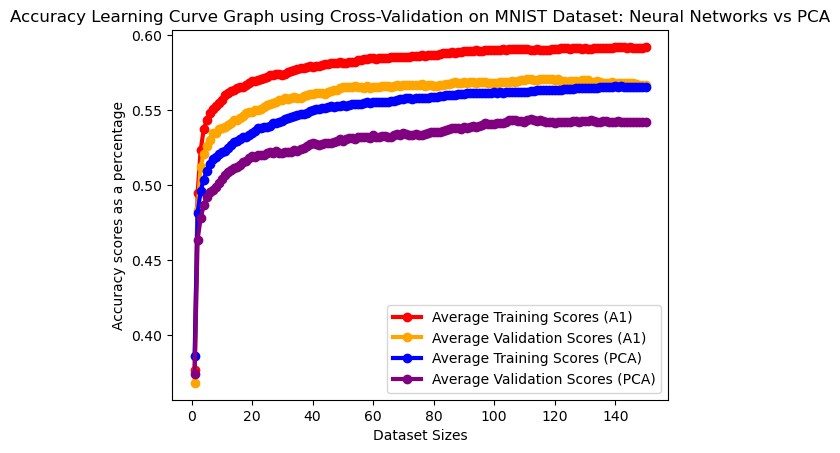

In [43]:
"""
Graphing the validation curves for both the baseline and the Dimension Reduced datasets.
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_pca,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (PCA)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_pca,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (PCA)"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Accuracy Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs PCA")

plt.legend()

plt.show()

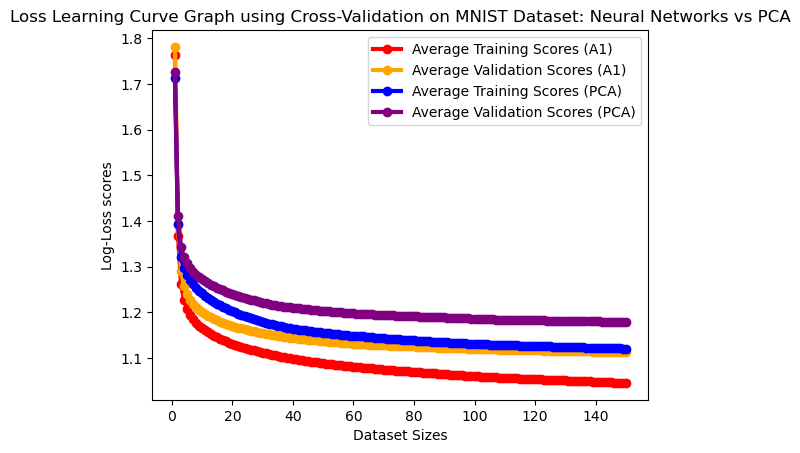

In [44]:
"""
Plotting the results into a loss learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)
# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_pca,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (PCA)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_pca,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (PCA)"
)


# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Log-Loss scores')
# Naming Title
plt.title("Loss Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs PCA")

plt.legend()

plt.show()

In [61]:
"""
The analysis above showed us that the Kurtosis value is at a maximum around 11. Let's use that 
for our dimensional reduction
"""
algorithm = 'parallel'
whiten = 'arbitrary-variance'
fun = 'exp'
max_iter = 400
tol = 1e-1

icafinal = FastICA(
    n_components = 11,
    algorithm = algorithm,
    whiten = whiten,
    fun = fun,
    max_iter = max_iter,
    tol = tol,
    random_state = seed
)

icafinal.fit(train_features)

x_train_transformed_ica = icafinal.transform(train_features)
x_test_transformed_ica = icafinal.transform(test_features)

In [46]:
"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list_ica = []
avg_validation_scores_list_ica = []
avg_train_loss_values_ica = []
avg_validation_loss_values_ica = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(x_train_transformed_ica, train_labels, test_size=0.2, random_state=seed)
    
    clf.fit(train_data, train_label)
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list_ica.append(accuracy_score)
    avg_validation_scores_list_ica.append(validation_score)
    avg_train_loss_values_ica.append(train_loss_score)
    avg_validation_loss_values_ica.append(val_loss_score)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("=============================================")



/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 1 epoch
Training Score: 0.09958659838341458
Validation Score: 0.10241855873642645
Training Loss Score: 2.304894213476203
Validation Loss Score: 2.3041302145358675


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 2 epoch
Training Score: 0.16384895415561176
Validation Score: 0.1620187561697927
Training Loss Score: 2.298544398900195
Validation Loss Score: 2.298304425031577


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 3 epoch
Training Score: 0.13771826988338373
Validation Score: 0.13684600197433366
Training Loss Score: 2.2929890701728612
Validation Loss Score: 2.293132687967936


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 4 epoch
Training Score: 0.16261491947923737
Validation Score: 0.15930404738400789
Training Loss Score: 2.282890543807169
Validation Loss Score: 2.283059693459537


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 5 epoch
Training Score: 0.16449682236070834
Validation Score: 0.1634995064165844
Training Loss Score: 2.2650529316107297
Validation Loss Score: 2.2652952419190213


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 6 epoch
Training Score: 0.17874992287283273
Validation Score: 0.1758390918065153
Training Loss Score: 2.236147619257902
Validation Loss Score: 2.2364356397605443


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 7 epoch
Training Score: 0.20781143950144998
Validation Score: 0.20409674234945707
Training Loss Score: 2.197377843556843
Validation Loss Score: 2.197611759053508


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 8 epoch
Training Score: 0.22798790646017153
Validation Score: 0.2266781836130306
Training Loss Score: 2.1514014738363505
Validation Loss Score: 2.1518037370610514


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 9 epoch
Training Score: 0.24733140001234036
Validation Score: 0.24099210266535045
Training Loss Score: 2.10085956890287
Validation Loss Score: 2.101719913907501


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 10 epoch
Training Score: 0.2618313074597396
Validation Score: 0.2550592300098717
Training Loss Score: 2.0500800019613603
Validation Loss Score: 2.0514360451404476


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 11 epoch
Training Score: 0.2756216449682236
Validation Score: 0.2707305034550839
Training Loss Score: 2.001074963884685
Validation Loss Score: 2.0030338025774945


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 12 epoch
Training Score: 0.2887949651385204
Validation Score: 0.2817127344521224
Training Loss Score: 1.953887561799343
Validation Loss Score: 1.9564515372925524


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 13 epoch
Training Score: 0.3011661627691738
Validation Score: 0.2936821322803554
Training Loss Score: 1.908963536719988
Validation Loss Score: 1.912194356616268


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 14 epoch
Training Score: 0.3106990806441661
Validation Score: 0.3008390918065153
Training Loss Score: 1.8667321485814015
Validation Loss Score: 1.8706027111359917


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 15 epoch
Training Score: 0.316344789288579
Validation Score: 0.30836623889437315
Training Loss Score: 1.8276427096347085
Validation Loss Score: 1.8323628448008882


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 16 epoch
Training Score: 0.3217128401308077
Validation Score: 0.3140424481737414
Training Loss Score: 1.7916370692135763
Validation Loss Score: 1.7970231468630864


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 17 epoch
Training Score: 0.3275128031097674
Validation Score: 0.319101678183613
Training Loss Score: 1.758912428878466
Validation Loss Score: 1.7649937708388779


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 18 epoch
Training Score: 0.33170852100944037
Validation Score: 0.32366732477788746
Training Loss Score: 1.7291535012179713
Validation Loss Score: 1.7359629847487856


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 19 epoch
Training Score: 0.3465477879928426
Validation Score: 0.3373642645607108
Training Loss Score: 1.703060838205791
Validation Loss Score: 1.7105835695502927


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 20 epoch
Training Score: 0.35564879373110386
Validation Score: 0.3474827245804541
Training Loss Score: 1.6791888689806194
Validation Loss Score: 1.6873061374202427


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 21 epoch
Training Score: 0.3618189671129759
Validation Score: 0.35402270483711745
Training Loss Score: 1.6575877825693537
Validation Loss Score: 1.6663758302336766


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 22 epoch
Training Score: 0.36829764916394153
Validation Score: 0.36216683119447185
Training Loss Score: 1.6386135940895372
Validation Loss Score: 1.6478971540198397


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 23 epoch
Training Score: 0.37422101561053867
Validation Score: 0.3699407699901283
Training Loss Score: 1.6213790664681316
Validation Loss Score: 1.6310617513980703


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 24 epoch
Training Score: 0.37918800518294565
Validation Score: 0.37314906219151034
Training Loss Score: 1.6060642902409337
Validation Loss Score: 1.6161133218551378


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 25 epoch
Training Score: 0.38304436354661564
Validation Score: 0.37857847976307996
Training Loss Score: 1.592687632040631
Validation Loss Score: 1.6031464443565957


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 26 epoch
Training Score: 0.3869007219102857
Validation Score: 0.3805528134254689
Training Loss Score: 1.5806892710458422
Validation Loss Score: 1.591505780171008


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 27 epoch
Training Score: 0.3904794224717715
Validation Score: 0.38536525172754194
Training Loss Score: 1.570015713020288
Validation Loss Score: 1.5812622179071993


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 28 epoch
Training Score: 0.3940889739001666
Validation Score: 0.38770977295162884
Training Loss Score: 1.5606680028188882
Validation Loss Score: 1.5723527165480147


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 29 epoch
Training Score: 0.39627938545073116
Validation Score: 0.38943731490621913
Training Loss Score: 1.5523432546138634
Validation Loss Score: 1.5644197518605671


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 30 epoch
Training Score: 0.39729746405874006
Validation Score: 0.3915350444225074
Training Loss Score: 1.544899108881242
Validation Loss Score: 1.5573476956263244


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 31 epoch
Training Score: 0.3987166039365706
Validation Score: 0.3923988153998026
Training Loss Score: 1.5385485789964923
Validation Loss Score: 1.551378383505165


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 32 epoch
Training Score: 0.4069537854013698
Validation Score: 0.39375616979269495
Training Loss Score: 1.5324417928231022
Validation Loss Score: 1.5456394435743137


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 33 epoch
Training Score: 0.40821867094465353
Validation Score: 0.39474333662388944
Training Loss Score: 1.5270184932474486
Validation Loss Score: 1.54053891434068


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 34 epoch
Training Score: 0.40902079348429693
Validation Score: 0.39622408687068117
Training Loss Score: 1.5221908305085614
Validation Loss Score: 1.5360058757245039


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 35 epoch
Training Score: 0.4099771703584871
Validation Score: 0.39758144126357353
Training Loss Score: 1.5176560033202238
Validation Loss Score: 1.5317081941498427


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 36 epoch
Training Score: 0.4113963102363176
Validation Score: 0.39992596248766044
Training Loss Score: 1.513708549812828
Validation Loss Score: 1.5280165925834546


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 37 epoch
Training Score: 0.4122601345097797
Validation Score: 0.40078973346495556
Training Loss Score: 1.5100238839369486
Validation Loss Score: 1.5245703065999257


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 38 epoch
Training Score: 0.41275374838032947
Validation Score: 0.40017275419545906
Training Loss Score: 1.5066273431211474
Validation Loss Score: 1.5213947999835242


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 39 epoch
Training Score: 0.41377182698833836
Validation Score: 0.4025172754195459
Training Loss Score: 1.503470076092941
Validation Loss Score: 1.5184546214793964


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 40 epoch
Training Score: 0.4144196951934349
Validation Score: 0.40325765054294177
Training Loss Score: 1.500655330732826
Validation Loss Score: 1.5158908165208183


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 41 epoch
Training Score: 0.41503671253162217
Validation Score: 0.4038746298124383
Training Loss Score: 1.498049370376301
Validation Loss Score: 1.5135718181077806


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 42 epoch
Training Score: 0.41549947553526256
Validation Score: 0.40424481737413626
Training Loss Score: 1.4955573318701403
Validation Loss Score: 1.5113081402435509


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 43 epoch
Training Score: 0.41617819460726846
Validation Score: 0.40597235932872655
Training Loss Score: 1.492994296929177
Validation Loss Score: 1.5089636722044524


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 44 epoch
Training Score: 0.4172271240821867
Validation Score: 0.40609575518262586
Training Loss Score: 1.4905473474258888
Validation Loss Score: 1.5067254779984522


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 45 epoch
Training Score: 0.41759733448509906
Validation Score: 0.40695952615992104
Training Loss Score: 1.4882827415337356
Validation Loss Score: 1.5046575879224644


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 46 epoch
Training Score: 0.41864626396001725
Validation Score: 0.408563672260612
Training Loss Score: 1.4860716660185451
Validation Loss Score: 1.502662306661821


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 47 epoch
Training Score: 0.4192632812982045
Validation Score: 0.4093040473840079
Training Loss Score: 1.4837271380208312
Validation Loss Score: 1.5005403165638915


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 48 epoch
Training Score: 0.41975689516875425
Validation Score: 0.41004442250740375
Training Loss Score: 1.481396518700929
Validation Loss Score: 1.4984218100270466


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 49 epoch
Training Score: 0.4204973159745789
Validation Score: 0.41127838104639686
Training Loss Score: 1.4792528596526493
Validation Loss Score: 1.4965253767177873


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 50 epoch
Training Score: 0.4217313506509533
Validation Score: 0.4122655478775913
Training Loss Score: 1.4773266573320638
Validation Loss Score: 1.494880717064715


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 51 epoch
Training Score: 0.4222866662553218
Validation Score: 0.4136229022704837
Training Loss Score: 1.4750910960795276
Validation Loss Score: 1.4928595102061208


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 52 epoch
Training Score: 0.4232738939964213
Validation Score: 0.41510365251727543
Training Loss Score: 1.4729504719000759
Validation Loss Score: 1.4909484332712137


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 53 epoch
Training Score: 0.4246621830073425
Validation Score: 0.4165844027640671
Training Loss Score: 1.4704467633118432
Validation Loss Score: 1.488651628198059


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 54 epoch
Training Score: 0.42564941074844204
Validation Score: 0.4178183613030602
Training Loss Score: 1.4677627107194777
Validation Loss Score: 1.486196755197898


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 55 epoch
Training Score: 0.42697599802554453
Validation Score: 0.418928923988154
Training Loss Score: 1.465011948046383
Validation Loss Score: 1.4837080404677696


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 56 epoch
Training Score: 0.4283334361695564
Validation Score: 0.4204096742349457
Training Loss Score: 1.4619846313323746
Validation Loss Score: 1.4808508389068555


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 57 epoch
Training Score: 0.4299685321157525
Validation Score: 0.42127344521224086
Training Loss Score: 1.4589222948867138
Validation Loss Score: 1.478075491772231


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 58 epoch
Training Score: 0.4312951193928549
Validation Score: 0.4230009871668312
Training Loss Score: 1.4559876654755195
Validation Loss Score: 1.4754974182129215


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 59 epoch
Training Score: 0.43259085580304807
Validation Score: 0.42509871668311944
Training Loss Score: 1.4530766404859738
Validation Loss Score: 1.4729448867693198


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 60 epoch
Training Score: 0.434040846547788
Validation Score: 0.42546890424481737
Training Loss Score: 1.4497066419658506
Validation Loss Score: 1.469988959536014


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 61 epoch
Training Score: 0.4356450916270747
Validation Score: 0.42657946692991117
Training Loss Score: 1.4463768018670113
Validation Loss Score: 1.4671095086336496


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 62 epoch
Training Score: 0.4374344419078176
Validation Score: 0.4286771964461994
Training Loss Score: 1.442847108714581
Validation Loss Score: 1.464093558697932


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 63 epoch
Training Score: 0.4401493181958413
Validation Score: 0.42917077986179664
Training Loss Score: 1.4388308631753477
Validation Loss Score: 1.4605236530864085


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 64 epoch
Training Score: 0.4423397297464059
Validation Score: 0.4317620927936821
Training Loss Score: 1.4350084247163069
Validation Loss Score: 1.457153109263156


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 65 epoch
Training Score: 0.44499290430061084
Validation Score: 0.43460019743336625
Training Loss Score: 1.43094706697653
Validation Loss Score: 1.4535340696339367


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 66 epoch
Training Score: 0.44780033318936263
Validation Score: 0.4359575518262586
Training Loss Score: 1.4269664644489608
Validation Loss Score: 1.4499972028241777


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 67 epoch
Training Score: 0.449805639538471
Validation Score: 0.4370681145113524
Training Loss Score: 1.4223927788686415
Validation Loss Score: 1.44587994136886


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 68 epoch
Training Score: 0.45193434935521687
Validation Score: 0.4391658440276407
Training Loss Score: 1.4175269539037958
Validation Loss Score: 1.4414765245110155


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 69 epoch
Training Score: 0.45403220830505336
Validation Score: 0.44163376110562685
Training Loss Score: 1.4129822201343305
Validation Loss Score: 1.4374410654582257


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 70 epoch
Training Score: 0.4567779354599864
Validation Score: 0.4439782823297137
Training Loss Score: 1.4081427420405639
Validation Loss Score: 1.4332078077674968


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 71 epoch
Training Score: 0.4599555747516505
Validation Score: 0.44656959526159923
Training Loss Score: 1.4037247631559202
Validation Loss Score: 1.4293202531811502


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 72 epoch
Training Score: 0.46239279323749
Validation Score: 0.44854392892398814
Training Loss Score: 1.3994277370108392
Validation Loss Score: 1.4254722213805648


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 73 epoch
Training Score: 0.46405874005059544
Validation Score: 0.4506416584402764
Training Loss Score: 1.3950020778075263
Validation Loss Score: 1.4215286301563133


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 74 epoch
Training Score: 0.467020423273894
Validation Score: 0.4529861796643633
Training Loss Score: 1.3907371702150984
Validation Loss Score: 1.4176533757661112


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 75 epoch
Training Score: 0.4691491330906398
Validation Score: 0.4534797630799605
Training Loss Score: 1.3864570720942708
Validation Loss Score: 1.4137632090070007


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 76 epoch
Training Score: 0.4714937989757512
Validation Score: 0.4563178677196446
Training Loss Score: 1.3825085166122482
Validation Loss Score: 1.410247141198346


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 77 epoch
Training Score: 0.4737459122601345
Validation Score: 0.45792201382033565
Training Loss Score: 1.378805004037313
Validation Loss Score: 1.4068221856445586


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 78 epoch
Training Score: 0.4755969642746961
Validation Score: 0.4600197433366239
Training Loss Score: 1.3753327791373682
Validation Loss Score: 1.403568745714776


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 79 epoch
Training Score: 0.4769852532856173
Validation Score: 0.461253701875617
Training Loss Score: 1.372184362114475
Validation Loss Score: 1.400665963701409


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 80 epoch
Training Score: 0.47818843709508235
Validation Score: 0.46396841066140176
Training Loss Score: 1.3691375069129197
Validation Loss Score: 1.3977641279489066


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 81 epoch
Training Score: 0.4787129018325415
Validation Score: 0.4655725567620928
Training Loss Score: 1.3659296591457442
Validation Loss Score: 1.394639348215415


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 82 epoch
Training Score: 0.47966927870673165
Validation Score: 0.466436327739388
Training Loss Score: 1.3634958113954656
Validation Loss Score: 1.392341506282755


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 83 epoch
Training Score: 0.48062565558092185
Validation Score: 0.4675468904244817
Training Loss Score: 1.361079954063501
Validation Loss Score: 1.3900025477232851


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 84 epoch
Training Score: 0.4814277781205652
Validation Score: 0.4671767028627838
Training Loss Score: 1.3586893244598057
Validation Loss Score: 1.387636280068715


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 85 epoch
Training Score: 0.4827235145307583
Validation Score: 0.4684106614017769
Training Loss Score: 1.3566418410283132
Validation Loss Score: 1.3856078460657466


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 86 epoch
Training Score: 0.48426605787622634
Validation Score: 0.4695212240868707
Training Loss Score: 1.3549679358827313
Validation Loss Score: 1.3840241105815285


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 87 epoch
Training Score: 0.4848522243475042
Validation Score: 0.4695212240868707
Training Loss Score: 1.3531059432397798
Validation Loss Score: 1.382124182514712


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 88 epoch
Training Score: 0.4858394520886037
Validation Score: 0.47186574531095754
Training Loss Score: 1.3515686381453806
Validation Loss Score: 1.3805545304536635


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 89 epoch
Training Score: 0.48682667982970323
Validation Score: 0.472852912142152
Training Loss Score: 1.3499864905979162
Validation Loss Score: 1.3788893561745335


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 90 epoch
Training Score: 0.48759795150243723
Validation Score: 0.47322309970384996
Training Loss Score: 1.3486995360019294
Validation Loss Score: 1.3775694080125096


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 91 epoch
Training Score: 0.4883075214413525
Validation Score: 0.4738400789733465
Training Loss Score: 1.3474696727044513
Validation Loss Score: 1.3762914266793416


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 92 epoch
Training Score: 0.4889553896464491
Validation Score: 0.4727295162882527
Training Loss Score: 1.3460093278779388
Validation Loss Score: 1.3746694285077885


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 93 epoch
Training Score: 0.490066020855186
Validation Score: 0.4711253701875617
Training Loss Score: 1.3449826807598322
Validation Loss Score: 1.3736001855039541


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 94 epoch
Training Score: 0.4910532485962856
Validation Score: 0.47186574531095754
Training Loss Score: 1.3440853330240705
Validation Loss Score: 1.372703226696102


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 95 epoch
Training Score: 0.491608564200654
Validation Score: 0.4726061204343534
Training Loss Score: 1.3431941017480902
Validation Loss Score: 1.3717620488958355


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 96 epoch
Training Score: 0.4922564324057506
Validation Score: 0.4739634748272458
Training Loss Score: 1.3424393553183445
Validation Loss Score: 1.3709870612841364


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 97 epoch
Training Score: 0.4921638798050225
Validation Score: 0.4756910167818361
Training Loss Score: 1.3417603375440255
Validation Loss Score: 1.370276578544626


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 98 epoch
Training Score: 0.49296600234466587
Validation Score: 0.476431391905232
Training Loss Score: 1.3406394438931901
Validation Loss Score: 1.3689511920558828


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 99 epoch
Training Score: 0.49361387054976247
Validation Score: 0.4776653504442251
Training Loss Score: 1.3398041167563404
Validation Loss Score: 1.368005985370514


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 100 epoch
Training Score: 0.49453939655704326
Validation Score: 0.4779121421520237
Training Loss Score: 1.3392234630795061
Validation Loss Score: 1.3673778027002625


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 101 epoch
Training Score: 0.4945085456901339
Validation Score: 0.47815893385982233
Training Loss Score: 1.338546224355539
Validation Loss Score: 1.3665801018867476


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 102 epoch
Training Score: 0.4947245017584994
Validation Score: 0.4786525172754195
Training Loss Score: 1.3379773131855508
Validation Loss Score: 1.3659298612726707


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 103 epoch
Training Score: 0.4950947121614117
Validation Score: 0.47914610069101676
Training Loss Score: 1.3373243463803561
Validation Loss Score: 1.3651632670909037


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 104 epoch
Training Score: 0.49521811562904916
Validation Score: 0.4795162882527147
Training Loss Score: 1.3368457849662294
Validation Loss Score: 1.3646412885340484


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 105 epoch
Training Score: 0.4956500277657802
Validation Score: 0.4807502467917078
Training Loss Score: 1.336281477715773
Validation Loss Score: 1.3640010385457568


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 106 epoch
Training Score: 0.49571172949959896
Validation Score: 0.4821076011846002
Training Loss Score: 1.33582196712308
Validation Loss Score: 1.3634212608924994


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 107 epoch
Training Score: 0.49660640463997036
Validation Score: 0.4833415597235933
Training Loss Score: 1.335482115504759
Validation Loss Score: 1.3630350935328295


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 108 epoch
Training Score: 0.4967298081076078
Validation Score: 0.48297137216189534
Training Loss Score: 1.3348411195951257
Validation Loss Score: 1.3622884530715833


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 109 epoch
Training Score: 0.4967298081076078
Validation Score: 0.48284797630799603
Training Loss Score: 1.334348085514295
Validation Loss Score: 1.3617093098402542


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 110 epoch
Training Score: 0.49700746590979206
Validation Score: 0.48284797630799603
Training Loss Score: 1.3339393056290691
Validation Loss Score: 1.3612413869547726


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 111 epoch
Training Score: 0.497346825445795
Validation Score: 0.4826011846001974
Training Loss Score: 1.3335393773089461
Validation Loss Score: 1.3607710400614157


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 112 epoch
Training Score: 0.49731597457888566
Validation Score: 0.48297137216189534
Training Loss Score: 1.333087913357014
Validation Loss Score: 1.3602502687169196


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 113 epoch
Training Score: 0.4979021410501635
Validation Score: 0.48321816386969396
Training Loss Score: 1.332768206303349
Validation Loss Score: 1.3598852105115744


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 114 epoch
Training Score: 0.49787129018325416
Validation Score: 0.48309476801579465
Training Loss Score: 1.3321458186993125
Validation Loss Score: 1.3591571625878478


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 115 epoch
Training Score: 0.49808724625161965
Validation Score: 0.4838351431391905
Training Loss Score: 1.3317022694126608
Validation Loss Score: 1.3586595574564435


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 116 epoch
Training Score: 0.49864256185598815
Validation Score: 0.4839585389930898
Training Loss Score: 1.3312529061013432
Validation Loss Score: 1.358137273234568


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 117 epoch
Training Score: 0.49888936879126305
Validation Score: 0.48432872655478776
Training Loss Score: 1.3308840401684259
Validation Loss Score: 1.3577060256596647


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 118 epoch
Training Score: 0.4987659653236256
Validation Score: 0.4846989141164857
Training Loss Score: 1.3306197433969142
Validation Loss Score: 1.357434507987754


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 119 epoch
Training Score: 0.49888936879126305
Validation Score: 0.4846989141164857
Training Loss Score: 1.3303069774527412
Validation Loss Score: 1.357094028622764


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 120 epoch
Training Score: 0.49941383352872215
Validation Score: 0.48531589338598224
Training Loss Score: 1.32996789273461
Validation Loss Score: 1.3567167566795253


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 121 epoch
Training Score: 0.49966064046399705
Validation Score: 0.4856860809476802
Training Loss Score: 1.3296273236226448
Validation Loss Score: 1.3563701205652092


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 122 epoch
Training Score: 0.5002468069352749
Validation Score: 0.48630306021717673
Training Loss Score: 1.3292192246280932
Validation Loss Score: 1.3559232149593816


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 123 epoch
Training Score: 0.5004936138705498
Validation Score: 0.4866732477788746
Training Loss Score: 1.3288855818861112
Validation Loss Score: 1.3555433211658143


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 124 epoch
Training Score: 0.5007404208058246
Validation Score: 0.48692003948667323
Training Loss Score: 1.3283677807377472
Validation Loss Score: 1.3549420300034676


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 125 epoch
Training Score: 0.5008946751403714
Validation Score: 0.48815399802566634
Training Loss Score: 1.3281209480255622
Validation Loss Score: 1.354677166229462


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 126 epoch
Training Score: 0.5010180786080088
Validation Score: 0.48938795656465944
Training Loss Score: 1.3279331134705774
Validation Loss Score: 1.3544855133632778


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 127 epoch
Training Score: 0.5017276485469242
Validation Score: 0.4886475814412636
Training Loss Score: 1.3273783444038159
Validation Loss Score: 1.3538661780632055


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 128 epoch
Training Score: 0.5017584994138335
Validation Score: 0.4887709772951629
Training Loss Score: 1.3269824930652558
Validation Loss Score: 1.353423474282141


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 129 epoch
Training Score: 0.5017584994138335
Validation Score: 0.4898815399802567
Training Loss Score: 1.3266805795910508
Validation Loss Score: 1.3530951310768715


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 130 epoch
Training Score: 0.5021595606836552
Validation Score: 0.4903751233958539
Training Loss Score: 1.326378987380999
Validation Loss Score: 1.3527799096312085


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 131 epoch
Training Score: 0.5018819028814709
Validation Score: 0.4909921026653504
Training Loss Score: 1.3261305416197227
Validation Loss Score: 1.3525173178295875


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 132 epoch
Training Score: 0.5020361572160178
Validation Score: 0.49148568608094767
Training Loss Score: 1.3258664762051289
Validation Loss Score: 1.352235014055203


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 133 epoch
Training Score: 0.5024372184858394
Validation Score: 0.49123889437314905
Training Loss Score: 1.3255840788791542
Validation Loss Score: 1.3519217510846704


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 134 epoch
Training Score: 0.5021904115505645
Validation Score: 0.491609081934847
Training Loss Score: 1.3254289820740046
Validation Loss Score: 1.3517627906157919


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 135 epoch
Training Score: 0.5026840254211143
Validation Score: 0.49234945705824285
Training Loss Score: 1.3253082394017555
Validation Loss Score: 1.3516452640208882


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 136 epoch
Training Score: 0.5031159375578453
Validation Score: 0.49247285291214216
Training Loss Score: 1.3248957749094286
Validation Loss Score: 1.3511806078750885


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 137 epoch
Training Score: 0.5033627444931202
Validation Score: 0.49333662388943733
Training Loss Score: 1.3245519713469966
Validation Loss Score: 1.3507925710190407


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 138 epoch
Training Score: 0.5035169988276671
Validation Score: 0.49346001974333664
Training Loss Score: 1.3243129777112939
Validation Loss Score: 1.3505238269709048


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 139 epoch
Training Score: 0.5039180600974887
Validation Score: 0.49370681145113526
Training Loss Score: 1.3240536140913561
Validation Loss Score: 1.3502294199667042


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 140 epoch
Training Score: 0.504195717899673
Validation Score: 0.4938302073050346
Training Loss Score: 1.3238612052842456
Validation Loss Score: 1.3499878124050055


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 141 epoch
Training Score: 0.5043808231011292
Validation Score: 0.4944471865745311
Training Loss Score: 1.3235447059887717
Validation Loss Score: 1.3496080949350528


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 142 epoch
Training Score: 0.5045350774356759
Validation Score: 0.4946939782823297
Training Loss Score: 1.3232560532183608
Validation Loss Score: 1.3492618074014764


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 143 epoch
Training Score: 0.5049052878385882
Validation Score: 0.4949407699901283
Training Loss Score: 1.3230173647200718
Validation Loss Score: 1.348999084911308


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 144 epoch
Training Score: 0.5051212439069538
Validation Score: 0.4950641658440276
Training Loss Score: 1.3227410443491445
Validation Loss Score: 1.348673341435871


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 145 epoch
Training Score: 0.5052446473745912
Validation Score: 0.4949407699901283
Training Loss Score: 1.3224973221471075
Validation Loss Score: 1.3484056539747566


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 146 epoch
Training Score: 0.5050286913062257
Validation Score: 0.4949407699901283
Training Loss Score: 1.3223856116095773
Validation Loss Score: 1.3482858751186764


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 147 epoch
Training Score: 0.5055223051767754
Validation Score: 0.4950641658440276
Training Loss Score: 1.3220065633979616
Validation Loss Score: 1.3478536007095918


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 148 epoch
Training Score: 0.5055840069105942
Validation Score: 0.49531095755182625
Training Loss Score: 1.3217824314058668
Validation Loss Score: 1.347603291688069


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 149 epoch
Training Score: 0.5058925155796878
Validation Score: 0.49555774925962487
Training Loss Score: 1.3216299658601112
Validation Loss Score: 1.347427771878399
Run for 150 epoch
Training Score: 0.506170173381872
Validation Score: 0.49543435340572556
Training Loss Score: 1.3214388573243314
Validation Loss Score: 1.3472087840553508


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [62]:
"""
Computing Accuracy Score on the Test data
"""

clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=number_of_epochs,
    warm_start=warm_start,
    random_state=seed
)

clf.fit(x_train_transformed_ica, train_labels)
start_time = time.time()
score = clf.score(x_test_transformed_ica, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.5108840515326522
0.00436091423034668


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


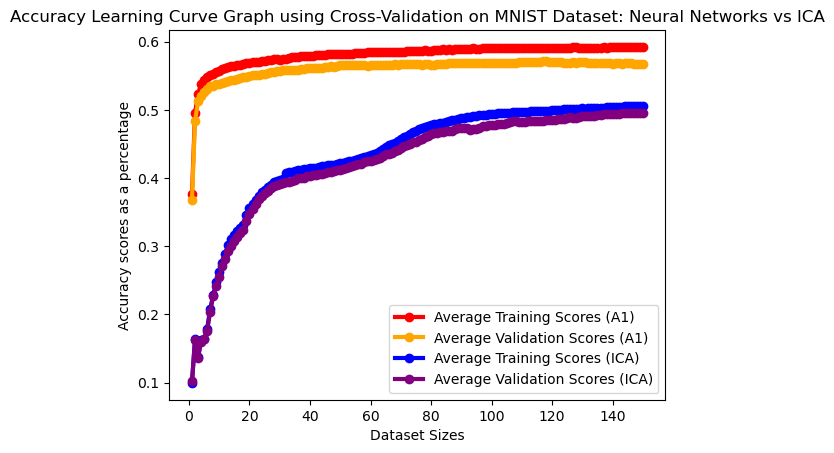

In [47]:
"""
Graphing the validation curves for both the baseline and the Dimension Reduced datasets.
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_ica,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (ICA)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_ica,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (ICA)"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Accuracy Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs ICA")

plt.legend()

plt.show()

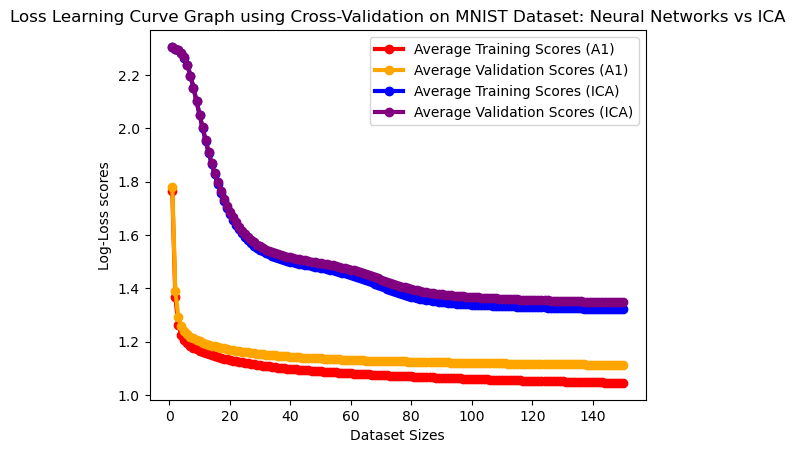

In [48]:
"""
Plotting the results into a loss learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)
# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_ica,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (ICA)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_ica,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (ICA)"
)


# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Log-Loss scores')
# Naming Title
plt.title("Loss Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs ICA")

plt.legend()

plt.show()

In [63]:
"""
The analysis above showed us that the Reconstruction Error value is at a good point around 7. Let's use that 
for our dimensional reduction
"""
# Hyperparameters for RP
density = 'auto'
eps = 0.1
compute_inverse_components = True
dense_output = False

rpfinal = SparseRandomProjection(
    n_components = 7,
    density = density,
    eps = eps,
    compute_inverse_components = compute_inverse_components,
    dense_output = dense_output,
    random_state = seed
)

rpfinal.fit(train_features)

x_train_transformed_rp = rpfinal.transform(train_features)
x_test_transformed_rp = rpfinal.transform(test_features)

In [50]:
"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list_rp = []
avg_validation_scores_list_rp = []
avg_train_loss_values_rp = []
avg_validation_loss_values_rp = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(x_train_transformed_rp, train_labels, test_size=0.2, random_state=seed)
    
    clf.fit(train_data, train_label)
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list_rp.append(accuracy_score)
    avg_validation_scores_list_rp.append(validation_score)
    avg_train_loss_values_rp.append(train_loss_score)
    avg_validation_loss_values_rp.append(val_loss_score)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("=============================================")



/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 1 epoch
Training Score: 0.30307891651755414
Validation Score: 0.2978775913129319
Training Loss Score: 1.832507559760462
Validation Loss Score: 1.835234491770511


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 2 epoch
Training Score: 0.411859073239958
Validation Score: 0.41029121421520237
Training Loss Score: 1.580780775914268
Validation Loss Score: 1.5866684817387446


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 3 epoch
Training Score: 0.4317578823964953
Validation Score: 0.4268262586377098
Training Loss Score: 1.5106022985273675
Validation Loss Score: 1.5218506249460289


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 4 epoch
Training Score: 0.43965570432529155
Validation Score: 0.4337364264560711
Training Loss Score: 1.48221948081867
Validation Loss Score: 1.496125768539689


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 5 epoch
Training Score: 0.4447152464984266
Validation Score: 0.43879565646594276
Training Loss Score: 1.465919921655436
Validation Loss Score: 1.4807112441023744


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 6 epoch
Training Score: 0.44841735052754983
Validation Score: 0.44064659427443237
Training Loss Score: 1.4551080401766643
Validation Loss Score: 1.4699327380784757


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 7 epoch
Training Score: 0.4508854198802986
Validation Score: 0.4437314906219151
Training Loss Score: 1.4467520296473186
Validation Loss Score: 1.4620966801631616


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 8 epoch
Training Score: 0.45366199790214107
Validation Score: 0.4464461994076999
Training Loss Score: 1.439861096446243
Validation Loss Score: 1.4556601120602988


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 9 epoch
Training Score: 0.45566730425124946
Validation Score: 0.4502714708785785
Training Loss Score: 1.434367070970009
Validation Loss Score: 1.4509285254463096


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 10 epoch
Training Score: 0.4577034614672672
Validation Score: 0.45088845014807505
Training Loss Score: 1.4297106425147583
Validation Loss Score: 1.4470887512370139


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 11 epoch
Training Score: 0.4595236626149195
Validation Score: 0.45076505429417574
Training Loss Score: 1.4257868589452394
Validation Loss Score: 1.4437518495590513


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 12 epoch
Training Score: 0.46057259208983775
Validation Score: 0.45249259624876603
Training Loss Score: 1.4223801714425088
Validation Loss Score: 1.4408804293186281


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 13 epoch
Training Score: 0.46149811809711855
Validation Score: 0.456071076011846
Training Loss Score: 1.419502883291695
Validation Loss Score: 1.4384045396186247


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 14 epoch
Training Score: 0.46279385450731164
Validation Score: 0.45582428430404737
Training Loss Score: 1.4169145755535786
Validation Loss Score: 1.4363426472869574


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 15 epoch
Training Score: 0.46390448571604864
Validation Score: 0.456071076011846
Training Loss Score: 1.4144995509270764
Validation Loss Score: 1.4343521590455406


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 16 epoch
Training Score: 0.46412044178441414
Validation Score: 0.456071076011846
Training Loss Score: 1.4122493826985996
Validation Loss Score: 1.4326687774412206


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 17 epoch
Training Score: 0.4650768186586043
Validation Score: 0.4571816386969398
Training Loss Score: 1.4102596306175774
Validation Loss Score: 1.4311371516306925


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 18 epoch
Training Score: 0.4658789411982477
Validation Score: 0.45767522211253703
Training Loss Score: 1.4084263921700955
Validation Loss Score: 1.429773209079559


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 19 epoch
Training Score: 0.46705127414080333
Validation Score: 0.45890918065153014
Training Loss Score: 1.4066389646332846
Validation Loss Score: 1.4284499173940353


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 20 epoch
Training Score: 0.4678842475473561
Validation Score: 0.45792201382033565
Training Loss Score: 1.405044529181549
Validation Loss Score: 1.4273426017658972


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 21 epoch
Training Score: 0.4685938174862714
Validation Score: 0.45952615992102663
Training Loss Score: 1.4034873938246053
Validation Loss Score: 1.4262997584448998


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 22 epoch
Training Score: 0.46862466835318073
Validation Score: 0.4605133267522211
Training Loss Score: 1.4019869443073338
Validation Loss Score: 1.425159622975414


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 23 epoch
Training Score: 0.4692416856913679
Validation Score: 0.4616238894373149
Training Loss Score: 1.4006519699700648
Validation Loss Score: 1.424175539433939


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 24 epoch
Training Score: 0.4702597642993768
Validation Score: 0.4616238894373149
Training Loss Score: 1.3993810212248616
Validation Loss Score: 1.4232879073427658


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 25 epoch
Training Score: 0.470876781637564
Validation Score: 0.46199407699901285
Training Loss Score: 1.3980717272155663
Validation Loss Score: 1.4222814632308198


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 26 epoch
Training Score: 0.4710310359721108
Validation Score: 0.4632280355380059
Training Loss Score: 1.396955327512321
Validation Loss Score: 1.4215041661238053


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 27 epoch
Training Score: 0.47214166718084777
Validation Score: 0.4642152023692004
Training Loss Score: 1.3958425007579593
Validation Loss Score: 1.4207563703892934


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 28 epoch
Training Score: 0.47229592151539457
Validation Score: 0.4656959526159921
Training Loss Score: 1.3947891383500877
Validation Loss Score: 1.4200592478690013


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 29 epoch
Training Score: 0.47294378972049117
Validation Score: 0.4656959526159921
Training Loss Score: 1.3936963846110673
Validation Loss Score: 1.4193348396556087


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 30 epoch
Training Score: 0.47362250879249707
Validation Score: 0.4653257650542942
Training Loss Score: 1.392654431220486
Validation Loss Score: 1.418705079291522


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 31 epoch
Training Score: 0.47464058740050596
Validation Score: 0.4645853899308983
Training Loss Score: 1.3916216614046193
Validation Loss Score: 1.4180211956650548


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 32 epoch
Training Score: 0.47448633306595916
Validation Score: 0.464461994076999
Training Loss Score: 1.3907427095879146
Validation Loss Score: 1.4175536678953882


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 33 epoch
Training Score: 0.474733140001234
Validation Score: 0.4655725567620928
Training Loss Score: 1.3897283800358697
Validation Loss Score: 1.4167904500972963


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 34 epoch
Training Score: 0.4752267538717838
Validation Score: 0.4655725567620928
Training Loss Score: 1.388737762869475
Validation Loss Score: 1.4161395850770713


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 35 epoch
Training Score: 0.47587462207688036
Validation Score: 0.46507897334649556
Training Loss Score: 1.3878614787282018
Validation Loss Score: 1.415409615434907


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 36 epoch
Training Score: 0.4765224902819769
Validation Score: 0.46594274432379074
Training Loss Score: 1.3868771195699199
Validation Loss Score: 1.414663451349196


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 37 epoch
Training Score: 0.4770161041525267
Validation Score: 0.46594274432379074
Training Loss Score: 1.3860645001362581
Validation Loss Score: 1.4139784209187307


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 38 epoch
Training Score: 0.47772567409144195
Validation Score: 0.46680651530108586
Training Loss Score: 1.3852023776728424
Validation Loss Score: 1.413359206395082


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 39 epoch
Training Score: 0.47781822669217006
Validation Score: 0.46631293188548867
Training Loss Score: 1.3843991149920567
Validation Loss Score: 1.4127698616844526


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 40 epoch
Training Score: 0.4784043931634479
Validation Score: 0.4670533070088845
Training Loss Score: 1.3836236773906925
Validation Loss Score: 1.4123930950937147


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 41 epoch
Training Score: 0.4776331214907139
Validation Score: 0.4670533070088845
Training Loss Score: 1.3827971554374001
Validation Loss Score: 1.4118844754811415


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 42 epoch
Training Score: 0.4776948232245326
Validation Score: 0.46779368213228034
Training Loss Score: 1.3820316796296732
Validation Loss Score: 1.4112582605791097


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 43 epoch
Training Score: 0.478157586228173
Validation Score: 0.46779368213228034
Training Loss Score: 1.3812238944330877
Validation Loss Score: 1.4106693775474972


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 44 epoch
Training Score: 0.4785586474979947
Validation Score: 0.4685340572556762
Training Loss Score: 1.380420013722111
Validation Loss Score: 1.4101189402988212


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 45 epoch
Training Score: 0.47874375269945085
Validation Score: 0.4684106614017769
Training Loss Score: 1.3796330795690364
Validation Loss Score: 1.409586131998537


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 46 epoch
Training Score: 0.47895970876781635
Validation Score: 0.4685340572556762
Training Loss Score: 1.3789471119964452
Validation Loss Score: 1.4091366713978828


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 47 epoch
Training Score: 0.4797926821743691
Validation Score: 0.4685340572556762
Training Loss Score: 1.3782639286865728
Validation Loss Score: 1.4087947923006856


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 48 epoch
Training Score: 0.47982353304127845
Validation Score: 0.46964461994077
Training Loss Score: 1.3777111379307325
Validation Loss Score: 1.4084422663252236


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 49 epoch
Training Score: 0.4796384278398223
Validation Score: 0.4706317867719645
Training Loss Score: 1.3770550992387813
Validation Loss Score: 1.4080487868495486


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 50 epoch
Training Score: 0.47936077003763805
Validation Score: 0.47026159921026656
Training Loss Score: 1.3763368851538802
Validation Loss Score: 1.4074481993068424


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 51 epoch
Training Score: 0.4797309804405504
Validation Score: 0.47100197433366237
Training Loss Score: 1.375703646600057
Validation Loss Score: 1.407121001664776


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 52 epoch
Training Score: 0.4798852347750972
Validation Score: 0.4711253701875617
Training Loss Score: 1.3750906979243303
Validation Loss Score: 1.4066633652206666


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 53 epoch
Training Score: 0.4801011908434627
Validation Score: 0.47075518262586374
Training Loss Score: 1.3745268916786089
Validation Loss Score: 1.4061952313073707


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 54 epoch
Training Score: 0.4801937434441908
Validation Score: 0.47198914116485685
Training Loss Score: 1.3739935634770268
Validation Loss Score: 1.405762092616508


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 55 epoch
Training Score: 0.48093416425001545
Validation Score: 0.47211253701875616
Training Loss Score: 1.3733405695516487
Validation Loss Score: 1.4053652753928998


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 56 epoch
Training Score: 0.4810267168507435
Validation Score: 0.47211253701875616
Training Loss Score: 1.3728588452941595
Validation Loss Score: 1.4049970266248168


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 57 epoch
Training Score: 0.48139692725365585
Validation Score: 0.4724827245804541
Training Loss Score: 1.372316125927873
Validation Loss Score: 1.4046597579874098


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 58 epoch
Training Score: 0.48068735731474055
Validation Score: 0.4714955577492596
Training Loss Score: 1.3718912683001947
Validation Loss Score: 1.404373741516473


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 59 epoch
Training Score: 0.4809650151169248
Validation Score: 0.47211253701875616
Training Loss Score: 1.3713911193303818
Validation Loss Score: 1.4039704190342728


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 60 epoch
Training Score: 0.48077990991546865
Validation Score: 0.4713721618953603
Training Loss Score: 1.3709626102816532
Validation Loss Score: 1.4037896174335942


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 61 epoch
Training Score: 0.4811809711852903
Validation Score: 0.4706317867719645
Training Loss Score: 1.370435894100061
Validation Loss Score: 1.4033718937520436


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 62 epoch
Training Score: 0.4811809711852903
Validation Score: 0.46964461994077
Training Loss Score: 1.3699566139402717
Validation Loss Score: 1.4030401742732117


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 63 epoch
Training Score: 0.48167458505584004
Validation Score: 0.47075518262586374
Training Loss Score: 1.3695196269448615
Validation Loss Score: 1.4027595547115457


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 64 epoch
Training Score: 0.4822916023940273
Validation Score: 0.4714955577492596
Training Loss Score: 1.3690534749818992
Validation Loss Score: 1.4024941220631781


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 65 epoch
Training Score: 0.4821373480594805
Validation Score: 0.47174234945705823
Training Loss Score: 1.36849921473378
Validation Loss Score: 1.4021035526105132


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 66 epoch
Training Score: 0.48207564632566174
Validation Score: 0.47087857847976305
Training Loss Score: 1.3680796224092122
Validation Loss Score: 1.4018811634994


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 67 epoch
Training Score: 0.48222990066020854
Validation Score: 0.47198914116485685
Training Loss Score: 1.36755077349687
Validation Loss Score: 1.4015835059793404


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 68 epoch
Training Score: 0.48247670759548344
Validation Score: 0.4716189536031589
Training Loss Score: 1.3670575416648458
Validation Loss Score: 1.4012358372056855


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 69 epoch
Training Score: 0.48253840932930214
Validation Score: 0.47100197433366237
Training Loss Score: 1.3666030183624331
Validation Loss Score: 1.4009032191727766


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 70 epoch
Training Score: 0.48330968100203614
Validation Score: 0.47075518262586374
Training Loss Score: 1.3661561323432443
Validation Loss Score: 1.40069626608885


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 71 epoch
Training Score: 0.48340223360276424
Validation Score: 0.47075518262586374
Training Loss Score: 1.3656121773935515
Validation Loss Score: 1.400282040539309


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 72 epoch
Training Score: 0.4834330844696736
Validation Score: 0.4706317867719645
Training Loss Score: 1.3652155322061321
Validation Loss Score: 1.3999578435183158


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 73 epoch
Training Score: 0.4831862775343987
Validation Score: 0.47075518262586374
Training Loss Score: 1.3648286389424442
Validation Loss Score: 1.3997615988163303


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 74 epoch
Training Score: 0.48371074227185784
Validation Score: 0.47075518262586374
Training Loss Score: 1.3644341797661574
Validation Loss Score: 1.3995807601071522


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 75 epoch
Training Score: 0.4836798914049485
Validation Score: 0.47198914116485685
Training Loss Score: 1.3640250593556837
Validation Loss Score: 1.3992581105433233


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 76 epoch
Training Score: 0.4836798914049485
Validation Score: 0.4713721618953603
Training Loss Score: 1.3636130258019854
Validation Loss Score: 1.3989892043552696


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 77 epoch
Training Score: 0.4835873388042204
Validation Score: 0.4724827245804541
Training Loss Score: 1.3631499353727874
Validation Loss Score: 1.3985918703373845


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 78 epoch
Training Score: 0.48401925094095144
Validation Score: 0.4727295162882527
Training Loss Score: 1.362676168439001
Validation Loss Score: 1.3982943833093329


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 79 epoch
Training Score: 0.48411180354167954
Validation Score: 0.472852912142152
Training Loss Score: 1.3621226542642682
Validation Loss Score: 1.397942269152858


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 80 epoch
Training Score: 0.48448201394459184
Validation Score: 0.47309970384995065
Training Loss Score: 1.361743500955636
Validation Loss Score: 1.3977358561227409


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 81 epoch
Training Score: 0.4849139260813229
Validation Score: 0.472852912142152
Training Loss Score: 1.361410599254594
Validation Loss Score: 1.397514551239107


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 82 epoch
Training Score: 0.485006478682051
Validation Score: 0.4735932872655479
Training Loss Score: 1.360993862107183
Validation Loss Score: 1.3972599543900999


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 83 epoch
Training Score: 0.4851298821496884
Validation Score: 0.4735932872655479
Training Loss Score: 1.360603006606256
Validation Loss Score: 1.3970802513450598


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 84 epoch
Training Score: 0.48540753995187264
Validation Score: 0.47408687068114513
Training Loss Score: 1.3602233799627443
Validation Loss Score: 1.3968110443815935


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 85 epoch
Training Score: 0.4857468994878756
Validation Score: 0.4738400789733465
Training Loss Score: 1.3599551945564556
Validation Loss Score: 1.396729726870566


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 86 epoch
Training Score: 0.4858394520886037
Validation Score: 0.47433366238894376
Training Loss Score: 1.359596096814071
Validation Loss Score: 1.396526895851943


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 87 epoch
Training Score: 0.48636391682606284
Validation Score: 0.4739634748272458
Training Loss Score: 1.3592797084154948
Validation Loss Score: 1.396336376298013


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 88 epoch
Training Score: 0.48679582896279383
Validation Score: 0.47507403751233956
Training Loss Score: 1.3588984339113392
Validation Loss Score: 1.396200880010793


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 89 epoch
Training Score: 0.48633306595915343
Validation Score: 0.4751974333662389
Training Loss Score: 1.358624278839588
Validation Loss Score: 1.396183387212978


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 90 epoch
Training Score: 0.48695008329734063
Validation Score: 0.47470384995064163
Training Loss Score: 1.3583438418283214
Validation Loss Score: 1.396147181754239


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 91 epoch
Training Score: 0.4874745480347998
Validation Score: 0.4751974333662389
Training Loss Score: 1.3579772929221199
Validation Loss Score: 1.3959844160586963


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 92 epoch
Training Score: 0.4876288023693466
Validation Score: 0.47470384995064163
Training Loss Score: 1.3576205965925476
Validation Loss Score: 1.3958873311103799


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 93 epoch
Training Score: 0.4879990127722589
Validation Score: 0.47445705824284307
Training Loss Score: 1.3572743968386878
Validation Loss Score: 1.3957152810706137


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 94 epoch
Training Score: 0.48790646017153083
Validation Score: 0.47334649555774927
Training Loss Score: 1.3569505019639896
Validation Loss Score: 1.3955216160558812


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 95 epoch
Training Score: 0.48790646017153083
Validation Score: 0.47495064165844025
Training Loss Score: 1.356607855676771
Validation Loss Score: 1.3953362750568288


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 96 epoch
Training Score: 0.48790646017153083
Validation Score: 0.47495064165844025
Training Loss Score: 1.356287881066597
Validation Loss Score: 1.3951851046027601


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 97 epoch
Training Score: 0.48861603011044613
Validation Score: 0.4751974333662389
Training Loss Score: 1.3559828747426284
Validation Loss Score: 1.3949483597767007


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 98 epoch
Training Score: 0.4885543283766274
Validation Score: 0.4754442250740375
Training Loss Score: 1.355691239927901
Validation Loss Score: 1.3947891752515162


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 99 epoch
Training Score: 0.4884309249089899
Validation Score: 0.47581441263573543
Training Loss Score: 1.355490111572698
Validation Loss Score: 1.3947264946143696


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 100 epoch
Training Score: 0.4891404948479052
Validation Score: 0.4754442250740375
Training Loss Score: 1.3551958545600755
Validation Loss Score: 1.3945529796698792


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 101 epoch
Training Score: 0.48892453877953973
Validation Score: 0.4756910167818361
Training Loss Score: 1.3549803883148186
Validation Loss Score: 1.394407613249308


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 102 epoch
Training Score: 0.4892638983155427
Validation Score: 0.47618460019743336
Training Loss Score: 1.354697389732464
Validation Loss Score: 1.3941566899690851


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 103 epoch
Training Score: 0.48954155611772693
Validation Score: 0.47606120434353405
Training Loss Score: 1.3543915527842854
Validation Loss Score: 1.3938808710875852


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 104 epoch
Training Score: 0.4889553896464491
Validation Score: 0.47606120434353405
Training Loss Score: 1.3541769738213176
Validation Loss Score: 1.3937373583072152


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 105 epoch
Training Score: 0.489294749182452
Validation Score: 0.47581441263573543
Training Loss Score: 1.3538508847453787
Validation Loss Score: 1.3935550303396653


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 106 epoch
Training Score: 0.48907879311408653
Validation Score: 0.4756910167818361
Training Loss Score: 1.353592879265049
Validation Loss Score: 1.3934605346625664


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 107 epoch
Training Score: 0.4894181526500895
Validation Score: 0.4755676209279368
Training Loss Score: 1.3533570018994097
Validation Loss Score: 1.3934069154647888


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 108 epoch
Training Score: 0.4897266613191831
Validation Score: 0.476431391905232
Training Loss Score: 1.3529652494974753
Validation Loss Score: 1.3931694995937745


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 109 epoch
Training Score: 0.4897266613191831
Validation Score: 0.4765547877591313
Training Loss Score: 1.3527496138034063
Validation Loss Score: 1.3931781593291364


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 110 epoch
Training Score: 0.4900351699882767
Validation Score: 0.4766781836130306
Training Loss Score: 1.3525707437347145
Validation Loss Score: 1.3931006475762315


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 111 epoch
Training Score: 0.4900968717220954
Validation Score: 0.47717176702862785
Training Loss Score: 1.3522525546214035
Validation Loss Score: 1.3928656760503988


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 112 epoch
Training Score: 0.4898192139199111
Validation Score: 0.47630799605133267
Training Loss Score: 1.3520110329430903
Validation Loss Score: 1.392646213655027


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 113 epoch
Training Score: 0.4900351699882767
Validation Score: 0.47618460019743336
Training Loss Score: 1.351685440260015
Validation Loss Score: 1.3924802577675068


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 114 epoch
Training Score: 0.4899426173875486
Validation Score: 0.4756910167818361
Training Loss Score: 1.351457952646051
Validation Loss Score: 1.3923243029417416


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 115 epoch
Training Score: 0.4902511260566422
Validation Score: 0.4756910167818361
Training Loss Score: 1.3511461410381527
Validation Loss Score: 1.392130090178245


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 116 epoch
Training Score: 0.4902819769235516
Validation Score: 0.4756910167818361
Training Loss Score: 1.350918191642506
Validation Loss Score: 1.3920340171750092


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 117 epoch
Training Score: 0.489973468254458
Validation Score: 0.47593780848963474
Training Loss Score: 1.350693935649177
Validation Loss Score: 1.3919923523630082


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 118 epoch
Training Score: 0.489973468254458
Validation Score: 0.4755676209279368
Training Loss Score: 1.35038409530641
Validation Loss Score: 1.3917696727682078


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 119 epoch
Training Score: 0.4898809156537299
Validation Score: 0.47630799605133267
Training Loss Score: 1.3501261844571009
Validation Loss Score: 1.3915268383239408


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 120 epoch
Training Score: 0.4900351699882767
Validation Score: 0.476431391905232
Training Loss Score: 1.3498954378076045
Validation Loss Score: 1.3914144942766482


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 121 epoch
Training Score: 0.4900043191213673
Validation Score: 0.4753208292201382
Training Loss Score: 1.3496100517246736
Validation Loss Score: 1.3911741335174035


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 122 epoch
Training Score: 0.4901894243228235
Validation Score: 0.4754442250740375
Training Loss Score: 1.34938353443351
Validation Loss Score: 1.3909353949631855


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 123 epoch
Training Score: 0.490066020855186
Validation Score: 0.47593780848963474
Training Loss Score: 1.349197393682291
Validation Loss Score: 1.3907522182179086


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 124 epoch
Training Score: 0.4898809156537299
Validation Score: 0.476431391905232
Training Loss Score: 1.348889061271712
Validation Loss Score: 1.390508760088695


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 125 epoch
Training Score: 0.4900043191213673
Validation Score: 0.4765547877591313
Training Loss Score: 1.3486165063683586
Validation Loss Score: 1.3903580498346921


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 126 epoch
Training Score: 0.4904362312580984
Validation Score: 0.4769249753208292
Training Loss Score: 1.3484964740291603
Validation Loss Score: 1.3902809301981258


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 127 epoch
Training Score: 0.4900968717220954
Validation Score: 0.4765547877591313
Training Loss Score: 1.3483458944157136
Validation Loss Score: 1.390110608374791


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 128 epoch
Training Score: 0.4905904855926452
Validation Score: 0.4766781836130306
Training Loss Score: 1.348194168688316
Validation Loss Score: 1.3900633179407351


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 129 epoch
Training Score: 0.4905287838588264
Validation Score: 0.47704837117472854
Training Loss Score: 1.3479152914922818
Validation Loss Score: 1.3898294332717367


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 130 epoch
Training Score: 0.4907755907941013
Validation Score: 0.4777887462981244
Training Loss Score: 1.3477616505508452
Validation Loss Score: 1.3895669288051347


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 131 epoch
Training Score: 0.49071388906028257
Validation Score: 0.47729516288252716
Training Loss Score: 1.3475720482490918
Validation Loss Score: 1.3894221934201134


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 132 epoch
Training Score: 0.4904979329919171
Validation Score: 0.47741855873642647
Training Loss Score: 1.3474220220152886
Validation Loss Score: 1.3893706455232344


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 133 epoch
Training Score: 0.49071388906028257
Validation Score: 0.47717176702862785
Training Loss Score: 1.3472097138159602
Validation Loss Score: 1.3892311925418748


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 134 epoch
Training Score: 0.4904362312580984
Validation Score: 0.47704837117472854
Training Loss Score: 1.3470794855830275
Validation Loss Score: 1.3891377096418138


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 135 epoch
Training Score: 0.4911458011970136
Validation Score: 0.4776653504442251
Training Loss Score: 1.3467970145401276
Validation Loss Score: 1.388922690162232


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 136 epoch
Training Score: 0.4912075029308324
Validation Score: 0.47704837117472854
Training Loss Score: 1.3467155269747775
Validation Loss Score: 1.3889876836160895


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 137 epoch
Training Score: 0.4909915468624668
Validation Score: 0.4768015794669299
Training Loss Score: 1.3465673188503158
Validation Loss Score: 1.3888687598255558


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 138 epoch
Training Score: 0.4909606959955575
Validation Score: 0.47717176702862785
Training Loss Score: 1.3464038855196947
Validation Loss Score: 1.388748353089785


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 139 epoch
Training Score: 0.4908989942617388
Validation Score: 0.47741855873642647
Training Loss Score: 1.3462099521975317
Validation Loss Score: 1.3886716391350131


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 140 epoch
Training Score: 0.4913309063984698
Validation Score: 0.4768015794669299
Training Loss Score: 1.3460911289544288
Validation Loss Score: 1.3885799105273753


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 141 epoch
Training Score: 0.49142345899919787
Validation Score: 0.47630799605133267
Training Loss Score: 1.3458210300309639
Validation Loss Score: 1.3884065259910794


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 142 epoch
Training Score: 0.4913926081322885
Validation Score: 0.47606120434353405
Training Loss Score: 1.3456990474714274
Validation Loss Score: 1.3883862931206115


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 143 epoch
Training Score: 0.491608564200654
Validation Score: 0.4755676209279368
Training Loss Score: 1.34537389948351
Validation Loss Score: 1.3881380741461677


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 144 epoch
Training Score: 0.4915468624668353
Validation Score: 0.4755676209279368
Training Loss Score: 1.3452123387337696
Validation Loss Score: 1.3879958236197492


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 145 epoch
Training Score: 0.4917628185352008
Validation Score: 0.47593780848963474
Training Loss Score: 1.345088654466774
Validation Loss Score: 1.387900658244636


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 146 epoch
Training Score: 0.491608564200654
Validation Score: 0.4756910167818361
Training Loss Score: 1.34495939439938
Validation Loss Score: 1.3878629463415477


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 147 epoch
Training Score: 0.4919170728697476
Validation Score: 0.47593780848963474
Training Loss Score: 1.3448730483611155
Validation Loss Score: 1.3877673211824042


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 148 epoch
Training Score: 0.4917936694021102
Validation Score: 0.4754442250740375
Training Loss Score: 1.3447735045700813
Validation Loss Score: 1.3877861425364262


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 149 epoch
Training Score: 0.4917936694021102
Validation Score: 0.4754442250740375
Training Loss Score: 1.344579745305576
Validation Loss Score: 1.387648761194397
Run for 150 epoch
Training Score: 0.49157771333374467
Validation Score: 0.4754442250740375
Training Loss Score: 1.3444694221269455
Validation Loss Score: 1.3875016582352788


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [64]:
"""
Computing Accuracy Score on the Test data
"""

clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=number_of_epochs,
    warm_start=warm_start,
    random_state=seed
)

clf.fit(x_train_transformed_rp, train_labels)
start_time = time.time()
score = clf.score(x_test_transformed_rp, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.4911150599733452
0.004346132278442383


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


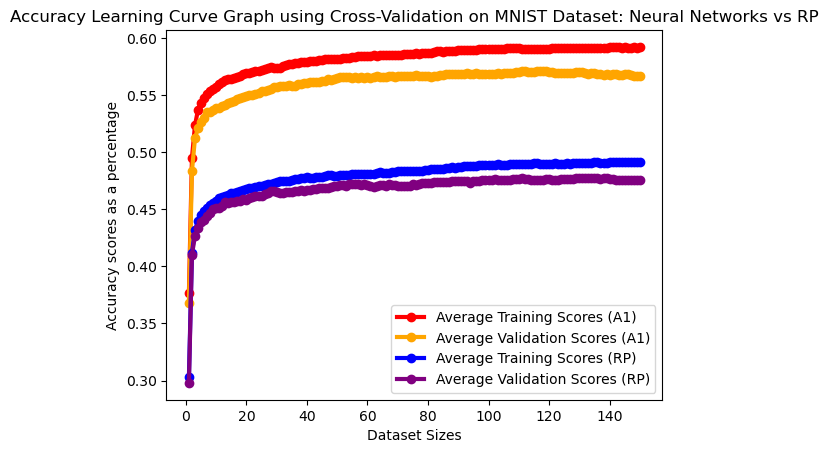

In [51]:
"""
Graphing the validation curves for both the baseline and the Dimension Reduced datasets.
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_rp,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (RP)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_rp,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (RP)"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Accuracy Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs RP")

plt.legend()

plt.show()

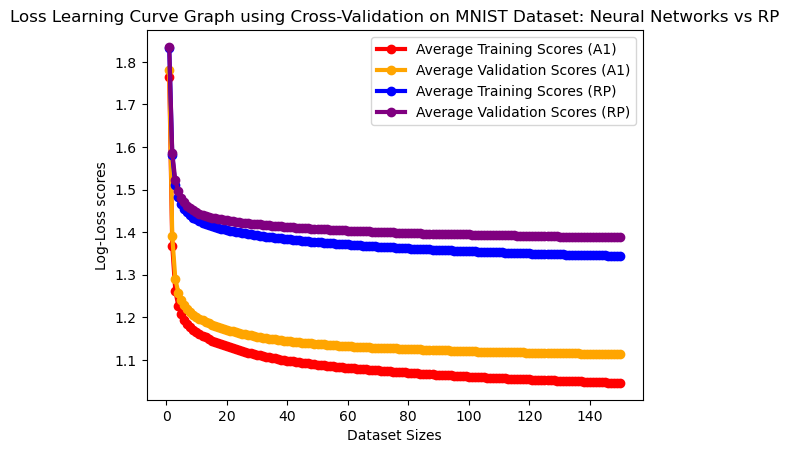

In [52]:
"""
Plotting the results into a loss learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)
# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_rp,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (RP)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_rp,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (RP)"
)


# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Log-Loss scores')
# Naming Title
plt.title("Loss Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs RP")

plt.legend()

plt.show()

In [65]:
"""
We want to actually set the model with n_components = 2 and use the best perplexity value
that we calculated from above. We want to use this to transform the data and reduce dimensions from 
784 -> 2.
"""
n_components = 2
init = "pca"
early_exaggeration = 12.0
learning_rate = "auto"
n_iter = 1000
n_iter_without_progress = 300

tfinal = TSNE(
    n_components = 2,
    perplexity = 45,
    init = init,
    early_exaggeration = early_exaggeration,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_iter_without_progress = n_iter_without_progress,
    random_state = seed
)

x_train_transformed_mani = tfinal.fit_transform(train_features)
x_test_transformed_mani = tfinal.fit_transform(test_features)

In [54]:
"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list_mani = []
avg_validation_scores_list_mani = []
avg_train_loss_values_mani = []
avg_validation_loss_values_mani = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(x_train_transformed_mani, train_labels, test_size=0.2, random_state=seed)
    
    clf.fit(train_data, train_label)
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list_mani.append(accuracy_score)
    avg_validation_scores_list_mani.append(validation_score)
    avg_train_loss_values_mani.append(train_loss_score)
    avg_validation_loss_values_mani.append(val_loss_score)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("=============================================")



/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 1 epoch
Training Score: 0.23076448448201395
Validation Score: 0.22741855873642647
Training Loss Score: 2.1165807107443912
Validation Loss Score: 2.129117684143687


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 2 epoch
Training Score: 0.26849509471216143
Validation Score: 0.26295656465942746
Training Loss Score: 1.975976473988334
Validation Loss Score: 1.985891505590549


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 3 epoch
Training Score: 0.2736780403529339
Validation Score: 0.2672754195459033
Training Loss Score: 1.9178818287280868
Validation Loss Score: 1.9286603907394488


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 4 epoch
Training Score: 0.28086629234281485
Validation Score: 0.27690029615004935
Training Loss Score: 1.8824866790146217
Validation Loss Score: 1.895216191575934


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 5 epoch
Training Score: 0.287560930462146
Validation Score: 0.2829466929911155
Training Loss Score: 1.8617898466429725
Validation Loss Score: 1.874241436455256


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 6 epoch
Training Score: 0.29215770963164067
Validation Score: 0.2883761105626851
Training Loss Score: 1.8484333137013695
Validation Loss Score: 1.8613290136449103


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 7 epoch
Training Score: 0.29502684025421116
Validation Score: 0.2928183613030602
Training Loss Score: 1.8398270478593788
Validation Loss Score: 1.853310168046593


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 8 epoch
Training Score: 0.3015672240389955
Validation Score: 0.2946692991115499
Training Loss Score: 1.8308258803506026
Validation Loss Score: 1.8447248599898192


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 9 epoch
Training Score: 0.30400444252483494
Validation Score: 0.29911154985192495
Training Loss Score: 1.8244529280304131
Validation Loss Score: 1.839463365785771


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 10 epoch
Training Score: 0.30804590608996113
Validation Score: 0.30256663376110565
Training Loss Score: 1.815855134051968
Validation Loss Score: 1.8329004184298145


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 11 epoch
Training Score: 0.3110692910470784
Validation Score: 0.3067620927936821
Training Loss Score: 1.808783674313007
Validation Loss Score: 1.8261157774650156


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 12 epoch
Training Score: 0.3146479916085642
Validation Score: 0.3120681145113524
Training Loss Score: 1.8030034593266338
Validation Loss Score: 1.8201016568657615


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 13 epoch
Training Score: 0.3168075522922194
Validation Score: 0.3149062191510365
Training Loss Score: 1.7987708505785012
Validation Loss Score: 1.81570295688183


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 14 epoch
Training Score: 0.31810328870241256
Validation Score: 0.31638696939782823
Training Loss Score: 1.7939340681067208
Validation Loss Score: 1.8106650711044192


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 15 epoch
Training Score: 0.3161905349540322
Validation Score: 0.31527640671273444
Training Loss Score: 1.7914545670971065
Validation Loss Score: 1.808056596431576


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 16 epoch
Training Score: 0.3181341395693219
Validation Score: 0.31354886475814414
Training Loss Score: 1.7868024141937915
Validation Loss Score: 1.8038332288847723


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 17 epoch
Training Score: 0.31862775343987165
Validation Score: 0.3146594274432379
Training Loss Score: 1.7839724934021055
Validation Loss Score: 1.8012602963247795


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 18 epoch
Training Score: 0.31791818350095635
Validation Score: 0.31539980256663375
Training Loss Score: 1.7798460483001424
Validation Loss Score: 1.7974047094683419


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 19 epoch
Training Score: 0.31995434071697415
Validation Score: 0.3168805528134255
Training Loss Score: 1.7776043307835907
Validation Loss Score: 1.7959400929828604


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 20 epoch
Training Score: 0.3195224285802431
Validation Score: 0.3161401776900296
Training Loss Score: 1.7754379778097142
Validation Loss Score: 1.7939430820104771


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 21 epoch
Training Score: 0.32087986672425495
Validation Score: 0.3161401776900296
Training Loss Score: 1.7725714622702056
Validation Loss Score: 1.7908267636214779


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 22 epoch
Training Score: 0.32245326093663235
Validation Score: 0.32070582428430405
Training Loss Score: 1.7700974327763033
Validation Loss Score: 1.7884752612968886


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 23 epoch
Training Score: 0.3237181464799161
Validation Score: 0.319101678183613
Training Loss Score: 1.7676537305343185
Validation Loss Score: 1.786301764390385


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 24 epoch
Training Score: 0.3223915592028136
Validation Score: 0.31860809476801577
Training Loss Score: 1.7660741627572003
Validation Loss Score: 1.7850638345546614


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 25 epoch
Training Score: 0.3219287961991732
Validation Score: 0.31860809476801577
Training Loss Score: 1.7643841895055783
Validation Loss Score: 1.7833352655084054


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 26 epoch
Training Score: 0.32165113839698894
Validation Score: 0.3181145113524186
Training Loss Score: 1.7632057457910617
Validation Loss Score: 1.7822811377794672


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 27 epoch
Training Score: 0.32180539273153574
Validation Score: 0.31552319842053306
Training Loss Score: 1.7622463355866012
Validation Loss Score: 1.7817119771473466


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 28 epoch
Training Score: 0.32189794533226385
Validation Score: 0.31342546890424483
Training Loss Score: 1.7609342989032124
Validation Loss Score: 1.7804234479264494


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 29 epoch
Training Score: 0.32606281236502743
Validation Score: 0.3171273445212241
Training Loss Score: 1.7600052930427945
Validation Loss Score: 1.7795764143360706


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 30 epoch
Training Score: 0.3271117418399457
Validation Score: 0.3181145113524186
Training Loss Score: 1.7592448514981818
Validation Loss Score: 1.778911332853497


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 31 epoch
Training Score: 0.32779046091195163
Validation Score: 0.3181145113524186
Training Loss Score: 1.7582057650243688
Validation Loss Score: 1.7782317438362119


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 32 epoch
Training Score: 0.3284691799839575
Validation Score: 0.31749753208292203
Training Loss Score: 1.7573834227427911
Validation Loss Score: 1.7775994929512346


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 33 epoch
Training Score: 0.3293330042574196
Validation Score: 0.31947186574531095
Training Loss Score: 1.7566767905292846
Validation Loss Score: 1.777228204168193


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 34 epoch
Training Score: 0.329024495588326
Validation Score: 0.31959526159921026
Training Loss Score: 1.7556555327493335
Validation Loss Score: 1.776208122347436


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 35 epoch
Training Score: 0.3300734250632443
Validation Score: 0.3209526159921027
Training Loss Score: 1.7551173372248654
Validation Loss Score: 1.7757103987086096


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 36 epoch
Training Score: 0.3299191707286975
Validation Score: 0.32354392892398814
Training Loss Score: 1.7544463754211692
Validation Loss Score: 1.7753932567326636


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 37 epoch
Training Score: 0.329703214660332
Validation Score: 0.3230503455083909
Training Loss Score: 1.7536783455748233
Validation Loss Score: 1.7746374237314877


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 38 epoch
Training Score: 0.3300734250632443
Validation Score: 0.32255676209279366
Training Loss Score: 1.7531424554542938
Validation Loss Score: 1.774099251069112


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 39 epoch
Training Score: 0.3294872585919664
Validation Score: 0.3230503455083909
Training Loss Score: 1.7529452317498275
Validation Loss Score: 1.7740935718808906


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 40 epoch
Training Score: 0.3298574689948788
Validation Score: 0.32206317867719647
Training Loss Score: 1.751890557585501
Validation Loss Score: 1.7731000735338356


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 41 epoch
Training Score: 0.3306595915345221
Validation Score: 0.3250246791707799
Training Loss Score: 1.7508746948019018
Validation Loss Score: 1.772387910728061


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 42 epoch
Training Score: 0.33084469673597827
Validation Score: 0.32477788746298125
Training Loss Score: 1.7503263985415645
Validation Loss Score: 1.7715872170658593


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 43 epoch
Training Score: 0.3309681002036157
Validation Score: 0.32477788746298125
Training Loss Score: 1.7496673173765325
Validation Loss Score: 1.7710296483438754


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 44 epoch
Training Score: 0.3310915036712532
Validation Score: 0.3241609081934847
Training Loss Score: 1.7490458437056713
Validation Loss Score: 1.7705216534900843


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 45 epoch
Training Score: 0.3318010736101685
Validation Score: 0.32650542941757155
Training Loss Score: 1.7483040117296762
Validation Loss Score: 1.7698210485745451


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 46 epoch
Training Score: 0.3331276608872709
Validation Score: 0.3268756169792695
Training Loss Score: 1.7472587889094155
Validation Loss Score: 1.7687802153558545


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 47 epoch
Training Score: 0.3343925464305547
Validation Score: 0.32662882527147086
Training Loss Score: 1.7465567073243324
Validation Loss Score: 1.7681252852234275


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 48 epoch
Training Score: 0.33494786203492316
Validation Score: 0.3283563672260612
Training Loss Score: 1.7460164328881886
Validation Loss Score: 1.7675457057023767


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 49 epoch
Training Score: 0.336305300178935
Validation Score: 0.3303307008884501
Training Loss Score: 1.7448167906486463
Validation Loss Score: 1.7663966536730784


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 50 epoch
Training Score: 0.33698401925094096
Validation Score: 0.32860315893385983
Training Loss Score: 1.7438398427475905
Validation Loss Score: 1.765507137673166


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 51 epoch
Training Score: 0.33843400999568085
Validation Score: 0.3300839091806515
Training Loss Score: 1.7431193965416818
Validation Loss Score: 1.7644771169481988


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 52 epoch
Training Score: 0.33815635219349666
Validation Score: 0.33193484698914116
Training Loss Score: 1.7424516676364252
Validation Loss Score: 1.7635427837237063


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 53 epoch
Training Score: 0.3391127290676868
Validation Score: 0.3323050345508391
Training Loss Score: 1.7421351067068382
Validation Loss Score: 1.7636127484149429


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 54 epoch
Training Score: 0.33991485160733015
Validation Score: 0.33292201382033565
Training Loss Score: 1.741262055220756
Validation Loss Score: 1.7623780332479255


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 55 epoch
Training Score: 0.34087122848152035
Validation Score: 0.33304540967423496
Training Loss Score: 1.7403256963011806
Validation Loss Score: 1.7616948475844214


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 56 epoch
Training Score: 0.34087122848152035
Validation Score: 0.3355133267522211
Training Loss Score: 1.7398598773539515
Validation Loss Score: 1.7610720185415927


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 57 epoch
Training Score: 0.34102548281606715
Validation Score: 0.3344027640671273
Training Loss Score: 1.738951790979654
Validation Loss Score: 1.760077282769478


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 58 epoch
Training Score: 0.3415807984204356
Validation Score: 0.3363770977295163
Training Loss Score: 1.7380853092151585
Validation Loss Score: 1.759490047360303


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 59 epoch
Training Score: 0.34102548281606715
Validation Score: 0.33464955577492594
Training Loss Score: 1.7378539925291587
Validation Loss Score: 1.7588003227852584


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 60 epoch
Training Score: 0.34117973715061395
Validation Score: 0.3351431391905232
Training Loss Score: 1.7373318405201377
Validation Loss Score: 1.758485874313464


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 61 epoch
Training Score: 0.34195100882334795
Validation Score: 0.3365004935834156
Training Loss Score: 1.7366432342360747
Validation Loss Score: 1.7577793842556806


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 62 epoch
Training Score: 0.3425988770284445
Validation Score: 0.3374876604146101
Training Loss Score: 1.7358927141931944
Validation Loss Score: 1.757312142294128


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 63 epoch
Training Score: 0.34296908743135684
Validation Score: 0.3374876604146101
Training Loss Score: 1.7350523457976057
Validation Loss Score: 1.7566274933910193


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 64 epoch
Training Score: 0.3435244030357253
Validation Score: 0.33884501480750245
Training Loss Score: 1.7345119861376308
Validation Loss Score: 1.7561698767751828


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 65 epoch
Training Score: 0.34420312210773124
Validation Score: 0.339461994076999
Training Loss Score: 1.7341008563355496
Validation Loss Score: 1.7561265575115033


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 66 epoch
Training Score: 0.344696735978281
Validation Score: 0.34020236920039487
Training Loss Score: 1.7334044338062344
Validation Loss Score: 1.7550156745657757


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 67 epoch
Training Score: 0.34466588511137164
Validation Score: 0.34118953603158936
Training Loss Score: 1.7329104909967517
Validation Loss Score: 1.7545631742516419


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 68 epoch
Training Score: 0.3450977972481027
Validation Score: 0.3403257650542942
Training Loss Score: 1.732161832444286
Validation Loss Score: 1.7539429306728747


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 69 epoch
Training Score: 0.34528290244955884
Validation Score: 0.3423000987166831
Training Loss Score: 1.7315420745583456
Validation Loss Score: 1.7537645798706463


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 70 epoch
Training Score: 0.3456222619855618
Validation Score: 0.34180651530108586
Training Loss Score: 1.730388449753653
Validation Loss Score: 1.7527352343985


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 71 epoch
Training Score: 0.3460850249892022
Validation Score: 0.3425468904244817
Training Loss Score: 1.7304096368838329
Validation Loss Score: 1.7525172764397203


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 72 epoch
Training Score: 0.34636268279138643
Validation Score: 0.34291707798617965
Training Loss Score: 1.7294734440258352
Validation Loss Score: 1.751507996049004


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 73 epoch
Training Score: 0.3472573579317579
Validation Score: 0.3447680157946693
Training Loss Score: 1.729225948776714
Validation Loss Score: 1.7513303064042394


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 74 epoch
Training Score: 0.3466403405935707
Validation Score: 0.3415597235932873
Training Loss Score: 1.7288884377696443
Validation Loss Score: 1.7510049460082706


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 75 epoch
Training Score: 0.3479669278706732
Validation Score: 0.34267028627838103
Training Loss Score: 1.7280214599160442
Validation Loss Score: 1.7503696135380202


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 76 epoch
Training Score: 0.3476275683346702
Validation Score: 0.3423000987166831
Training Loss Score: 1.727442635102367
Validation Loss Score: 1.749991212996483


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 77 epoch
Training Score: 0.34815203307212933
Validation Score: 0.3416831194471866
Training Loss Score: 1.726827580758429
Validation Loss Score: 1.7495649193715144


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 78 epoch
Training Score: 0.34855309434195103
Validation Score: 0.34267028627838103
Training Loss Score: 1.7258505928189298
Validation Loss Score: 1.7484821436606743


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 79 epoch
Training Score: 0.3475658666008515
Validation Score: 0.33859822309970383
Training Loss Score: 1.7257114145195331
Validation Loss Score: 1.7485491648139655


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 80 epoch
Training Score: 0.34793607700376383
Validation Score: 0.33970878578479763
Training Loss Score: 1.725241174427166
Validation Loss Score: 1.7480817559222168


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 81 epoch
Training Score: 0.34753501573394213
Validation Score: 0.33995557749259625
Training Loss Score: 1.7248971828332718
Validation Loss Score: 1.7476841937299963


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 82 epoch
Training Score: 0.3469488492626643
Validation Score: 0.341436327739388
Training Loss Score: 1.7246274625541513
Validation Loss Score: 1.7475194852026796


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 83 epoch
Training Score: 0.34676374406120813
Validation Score: 0.33896841066140176
Training Loss Score: 1.7242261951006177
Validation Loss Score: 1.7469472939386297


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 84 epoch
Training Score: 0.3467020423273894
Validation Score: 0.3395853899308983
Training Loss Score: 1.723660926795892
Validation Loss Score: 1.746828268104289


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 85 epoch
Training Score: 0.3473190596655766
Validation Score: 0.34180651530108586
Training Loss Score: 1.7233563435497523
Validation Loss Score: 1.7462784714820663


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 86 epoch
Training Score: 0.34713395446412043
Validation Score: 0.3423000987166831
Training Loss Score: 1.723046522651976
Validation Loss Score: 1.7459696368290594


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 87 epoch
Training Score: 0.3468562966619362
Validation Score: 0.3423000987166831
Training Loss Score: 1.7228250346232497
Validation Loss Score: 1.7459410662123571


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 88 epoch
Training Score: 0.347781822669217
Validation Score: 0.3420533070088845
Training Loss Score: 1.722064910721761
Validation Loss Score: 1.745050351464053


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 89 epoch
Training Score: 0.3486764978095884
Validation Score: 0.3420533070088845
Training Loss Score: 1.7218793985472014
Validation Loss Score: 1.7448503227207688


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 90 epoch
Training Score: 0.3485222434750416
Validation Score: 0.3421767028627838
Training Loss Score: 1.7217037666926203
Validation Loss Score: 1.7445611170971145


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 91 epoch
Training Score: 0.34805948047140123
Validation Score: 0.34180651530108586
Training Loss Score: 1.721216718641821
Validation Loss Score: 1.744266374014414


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 92 epoch
Training Score: 0.3483371382735855
Validation Score: 0.34304047384007896
Training Loss Score: 1.720761372980095
Validation Loss Score: 1.7436592792776746


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 93 epoch
Training Score: 0.3496020238168693
Validation Score: 0.3432872655478776
Training Loss Score: 1.720570276693679
Validation Loss Score: 1.7436811620108792


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 94 epoch
Training Score: 0.3494786203492318
Validation Score: 0.3455083909180652
Training Loss Score: 1.7202309662737783
Validation Loss Score: 1.7431227006826073


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 95 epoch
Training Score: 0.35049669895724067
Validation Score: 0.3461253701875617
Training Loss Score: 1.7197861770733143
Validation Loss Score: 1.742994238432334


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 96 epoch
Training Score: 0.3504041463565126
Validation Score: 0.34538499506416587
Training Loss Score: 1.719179512994774
Validation Loss Score: 1.7422630477618672


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 97 epoch
Training Score: 0.3509903128277905
Validation Score: 0.34698914116485685
Training Loss Score: 1.7190710735016217
Validation Loss Score: 1.7421862291941927


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 98 epoch
Training Score: 0.350434997223422
Validation Score: 0.34575518262586374
Training Loss Score: 1.7189572010148897
Validation Loss Score: 1.7420972914610906


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 99 epoch
Training Score: 0.35105201456160917
Validation Score: 0.3463721618953603
Training Loss Score: 1.7185365186470936
Validation Loss Score: 1.741664456598367


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 100 epoch
Training Score: 0.3509903128277905
Validation Score: 0.34587857847976305
Training Loss Score: 1.7178237397855538
Validation Loss Score: 1.7408392412550895


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 101 epoch
Training Score: 0.3507126550256062
Validation Score: 0.3455083909180652
Training Loss Score: 1.7176419479249088
Validation Loss Score: 1.740453591436515


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 102 epoch
Training Score: 0.35120626889615597
Validation Score: 0.34600197433366237
Training Loss Score: 1.7174622522459424
Validation Loss Score: 1.7404043405932967


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 103 epoch
Training Score: 0.3517924353674338
Validation Score: 0.34600197433366237
Training Loss Score: 1.7172673387849517
Validation Loss Score: 1.740279198075539


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 104 epoch
Training Score: 0.35151477756524957
Validation Score: 0.34587857847976305
Training Loss Score: 1.7168574705974189
Validation Loss Score: 1.7398797023742951


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 105 epoch
Training Score: 0.3517924353674338
Validation Score: 0.34587857847976305
Training Loss Score: 1.7167080028527935
Validation Loss Score: 1.7397810214493066


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 106 epoch
Training Score: 0.3512371197630653
Validation Score: 0.34575518262586374
Training Loss Score: 1.7164793306484385
Validation Loss Score: 1.739696159682838


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 107 epoch
Training Score: 0.3512371197630653
Validation Score: 0.34526159921026656
Training Loss Score: 1.7160655309582034
Validation Loss Score: 1.7392099781318657


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 108 epoch
Training Score: 0.3522551983710742
Validation Score: 0.34575518262586374
Training Loss Score: 1.716200587364479
Validation Loss Score: 1.7394403379741614


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 109 epoch
Training Score: 0.3517307336336151
Validation Score: 0.34587857847976305
Training Loss Score: 1.7161039274797638
Validation Loss Score: 1.7393169135596769


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 110 epoch
Training Score: 0.35160733016597767
Validation Score: 0.3443978282329714
Training Loss Score: 1.7150286455925687
Validation Loss Score: 1.738362792127984


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 111 epoch
Training Score: 0.3514839266983402
Validation Score: 0.3443978282329714
Training Loss Score: 1.7150935945386372
Validation Loss Score: 1.738375917053546


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 112 epoch
Training Score: 0.3521009440365274
Validation Score: 0.34427443237907207
Training Loss Score: 1.7149412572861422
Validation Loss Score: 1.73830615054993


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 113 epoch
Training Score: 0.3515456284321589
Validation Score: 0.3447680157946693
Training Loss Score: 1.7147194172895779
Validation Loss Score: 1.7381209811551843


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 114 epoch
Training Score: 0.35213179490343677
Validation Score: 0.3448914116485686
Training Loss Score: 1.7145198211509727
Validation Loss Score: 1.7376772318317173


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 115 epoch
Training Score: 0.35222434750416487
Validation Score: 0.3448914116485686
Training Loss Score: 1.7144979176288542
Validation Loss Score: 1.737538652115136


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 116 epoch
Training Score: 0.3517924353674338
Validation Score: 0.34427443237907207
Training Loss Score: 1.714492906316263
Validation Loss Score: 1.7378525723763862


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 117 epoch
Training Score: 0.35284136484235207
Validation Score: 0.34501480750246794
Training Loss Score: 1.7135914631726121
Validation Loss Score: 1.7369034230149896


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 118 epoch
Training Score: 0.3520083914357994
Validation Score: 0.3443978282329714
Training Loss Score: 1.7139978554440825
Validation Loss Score: 1.7373297455487864


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 119 epoch
Training Score: 0.3526562596408959
Validation Score: 0.34501480750246794
Training Loss Score: 1.7133822476447655
Validation Loss Score: 1.7368207352804637


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 120 epoch
Training Score: 0.3528722157092614
Validation Score: 0.3445212240868707
Training Loss Score: 1.7131850663638462
Validation Loss Score: 1.7364551748681099


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 121 epoch
Training Score: 0.3535817856481767
Validation Score: 0.34464461994077
Training Loss Score: 1.713055823337709
Validation Loss Score: 1.7364002354383028


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 122 epoch
Training Score: 0.353951996051089
Validation Score: 0.3456317867719645
Training Loss Score: 1.7126862842425257
Validation Loss Score: 1.7361177635607423


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 123 epoch
Training Score: 0.353951996051089
Validation Score: 0.34538499506416587
Training Loss Score: 1.7127134774510986
Validation Loss Score: 1.735911832188207


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 124 epoch
Training Score: 0.3537360399827235
Validation Score: 0.3443978282329714
Training Loss Score: 1.712627527578283
Validation Loss Score: 1.73605107105184


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 125 epoch
Training Score: 0.35416795211945457
Validation Score: 0.34526159921026656
Training Loss Score: 1.712453132780879
Validation Loss Score: 1.7357758611100462


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 126 epoch
Training Score: 0.35416795211945457
Validation Score: 0.3456317867719645
Training Loss Score: 1.7122661363775666
Validation Loss Score: 1.7355824698190856


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 127 epoch
Training Score: 0.35463071512309496
Validation Score: 0.34674234945705823
Training Loss Score: 1.7118002990810386
Validation Loss Score: 1.7354033836763165


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 128 epoch
Training Score: 0.354291355587092
Validation Score: 0.3472359328726555
Training Loss Score: 1.711336582065525
Validation Loss Score: 1.7347723300147884


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 129 epoch
Training Score: 0.3549083729252792
Validation Score: 0.34575518262586374
Training Loss Score: 1.7115437149387251
Validation Loss Score: 1.7352608021565799


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 130 epoch
Training Score: 0.3544147590547294
Validation Score: 0.346248766041461
Training Loss Score: 1.7110648107594324
Validation Loss Score: 1.7348926618336824


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 131 epoch
Training Score: 0.3543530573209107
Validation Score: 0.3455083909180652
Training Loss Score: 1.7106946966052803
Validation Loss Score: 1.7345194738598544


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 132 epoch
Training Score: 0.3552168815943728
Validation Score: 0.3466189536031589
Training Loss Score: 1.7105225401462771
Validation Loss Score: 1.7341714407293765


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 133 epoch
Training Score: 0.3551243289936447
Validation Score: 0.34809970384995065
Training Loss Score: 1.7106973488005355
Validation Loss Score: 1.7340920552352421


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 134 epoch
Training Score: 0.3548158203245511
Validation Score: 0.3484698914116486
Training Loss Score: 1.7103710559317953
Validation Loss Score: 1.733707027180886


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 135 epoch
Training Score: 0.3551243289936447
Validation Score: 0.3489634748272458
Training Loss Score: 1.7101031778306077
Validation Loss Score: 1.7333894982632732


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 136 epoch
Training Score: 0.3555870919972851
Validation Score: 0.3484698914116486
Training Loss Score: 1.7097798905206247
Validation Loss Score: 1.7329339925307485


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 137 epoch
Training Score: 0.3555870919972851
Validation Score: 0.34995064165844025
Training Loss Score: 1.7098143511494543
Validation Loss Score: 1.7328421708146757


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 138 epoch
Training Score: 0.35586474979946936
Validation Score: 0.3485932872655479
Training Loss Score: 1.7093646336023747
Validation Loss Score: 1.7325322765876658


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 139 epoch
Training Score: 0.3559881532671068
Validation Score: 0.3489634748272458
Training Loss Score: 1.7089645926486134
Validation Loss Score: 1.7319017295463055


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 140 epoch
Training Score: 0.35549453939655706
Validation Score: 0.34822309970384996
Training Loss Score: 1.7088061729850443
Validation Loss Score: 1.7318045791643017


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 141 epoch
Training Score: 0.355062627259826
Validation Score: 0.3485932872655479
Training Loss Score: 1.7079943146687142
Validation Loss Score: 1.7312556172305902


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 142 epoch
Training Score: 0.3553711359289196
Validation Score: 0.34822309970384996
Training Loss Score: 1.707289235562724
Validation Loss Score: 1.7304069879180781


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 143 epoch
Training Score: 0.35555624113037576
Validation Score: 0.3484698914116486
Training Loss Score: 1.7075351478269496
Validation Loss Score: 1.7304730947661804


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 144 epoch
Training Score: 0.35571049546492256
Validation Score: 0.3477295162882527
Training Loss Score: 1.7072573138634473
Validation Loss Score: 1.7305063742250264


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 145 epoch
Training Score: 0.35577219719874126
Validation Score: 0.34945705824284307
Training Loss Score: 1.7068703376862475
Validation Loss Score: 1.7301756687968906


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 146 epoch
Training Score: 0.356605170605294
Validation Score: 0.34686574531095754
Training Loss Score: 1.7066874965935863
Validation Loss Score: 1.7297042863946872


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 147 epoch
Training Score: 0.35848707348676495
Validation Score: 0.3495804540967424
Training Loss Score: 1.7063498634254606
Validation Loss Score: 1.7294792408034623


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 148 epoch
Training Score: 0.3584562226198556
Validation Score: 0.3495804540967424
Training Loss Score: 1.7062063524976618
Validation Loss Score: 1.7291566656926294


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 149 epoch
Training Score: 0.3595668538285926
Validation Score: 0.3484698914116486
Training Loss Score: 1.7058425359158096
Validation Loss Score: 1.7290399629101618
Run for 150 epoch
Training Score: 0.35888813475658665
Validation Score: 0.3515547877591313
Training Loss Score: 1.7059727811754661
Validation Loss Score: 1.7288751381229264


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [68]:
"""
Computing Accuracy Score on the Test data
"""

clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate='constant',
    max_iter=number_of_epochs,
    warm_start=warm_start,
    random_state=seed
)

clf.fit(x_train_transformed_mani, train_labels)
start_time = time.time()
score = clf.score(x_test_transformed_mani, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.14215904042647712
0.004063129425048828


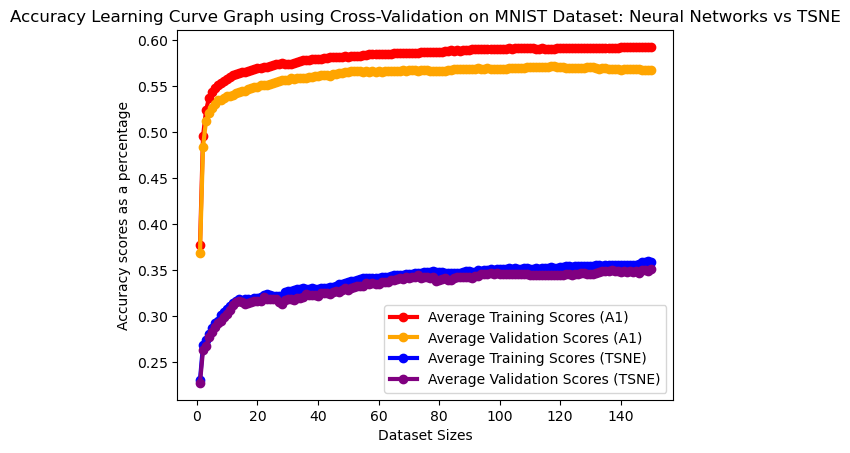

In [55]:
"""
Graphing the validation curves for both the baseline and the Dimension Reduced datasets.
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_mani,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (TSNE)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_mani,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (TSNE)"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Accuracy Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs TSNE")

plt.legend()

plt.show()

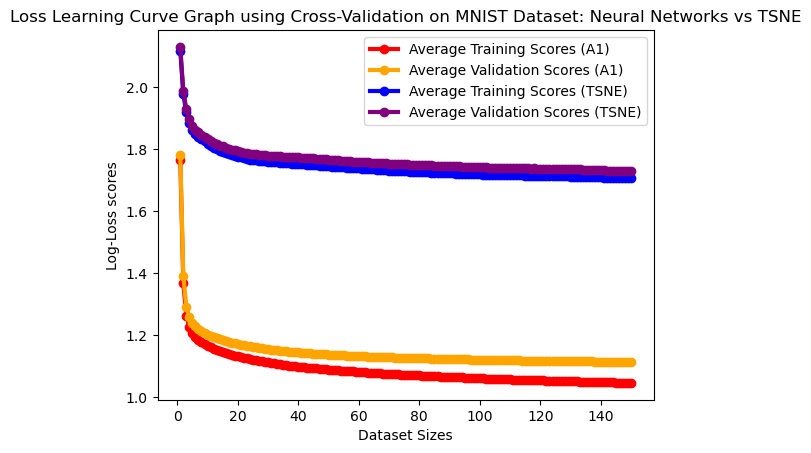

In [56]:
"""
Plotting the results into a loss learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)
# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_mani,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (TSNE)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_mani,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (TSNE)"
)


# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Log-Loss scores')
# Naming Title
plt.title("Loss Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs TSNE")

plt.legend()

plt.show()